# setting up

## imports and settings

In [1]:
import psycopg2
import sys, os
import numpy as np
import pandas as pd
import capstone_connect as creds
import pandas.io.sql as psql
import pandas_profiling

# for datetime manipulation
import datetime as dt

# for modeling
from sklearn.linear_model import LinearRegression, Lasso, LassoCV, RidgeCV
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV
from sklearn.preprocessing import StandardScaler,  PolynomialFeatures 
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor

from sklearn import metrics

# turning off warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# plotting related imports and settings

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')

# changing our pandas settings so that we can view all columns 
pd.set_option('max_columns', 999)


In [3]:
# optional installations

# !pip install pydot2
# !pip install graphviz
# !pip install pydotplus

# I had a lot of issues with graphviz on windows
# the instructions here [https://datascience.stackexchange.com/questions/37428/graphviz-not-working-when-imported-inside-pydotplus-graphvizs-executables-not]
# to install graphviz directly and set the path variable turned out the most useful.

## postgress database connections

In [4]:
# this function will allow us to make any SQL calls on the database

def query_db(sql):
    
    # Set up a connection to the postgres server.
    conn_string = "host="+ creds.PGHOST +" port="+ "5432" +" dbname="+ creds.PGDATABASE +" user=" + creds.PGUSER \
    +" password="+ creds.PGPASSWORD
    conn=psycopg2.connect(conn_string)
    print("Connected!")

    # Create a cursor object
    cursor = conn.cursor()
 
    print (sql)

    # Load the data
    data = pd.read_sql(sql, conn)

    print("Rows and columns returned:", data.shape)
    return (data)

## data

In [5]:
pkl_model = pd.read_pickle("./data/model_data2.pkl")

In [6]:
print(pkl_model.shape)
pkl_model.head()

(1592274, 13)


,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
22,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
23,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
24,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
25,18,1,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
26,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227


In [7]:
model_df = pkl_model.copy()

In [8]:
model_df['trip_month'].value_counts().sort_index()

1     157819
2     157773
3     178484
4     166695
5     171718
6     159636
7     156981
8     149224
9     150676
10    141842
11      1426
Name: trip_month, dtype: int64

# Group By

## subroute_name, trip_month, is_foreigner, bus_class

In [9]:
agg_df = model_df.groupby(['subroute_name', 'trip_month', 'is_foreigner', 'bus_class']).agg(
                                                                                                sum_tix = ('no_of_tickets', 'sum'),
                                                                                                avg_dur = ('duration_minutes', 'mean')
                                                                                                )


In [10]:
print(agg_df.shape)
agg_df

(470, 2)


sum_tix     avg_dur
subroute_name      trip_month is_foreigner bus_class                     
Mandalay-Naypyitaw 1          0            0            10533  340.155595
                                           1             1882  336.932862
                              1            0              337  343.373494
                                           1               68  347.647059
                   2          0            0             9781  345.814587
...                                                       ...         ...
Yangon-Taunggyi    10         1            1               75  682.500000
                   11         0            0              819  694.720280
                                           1              446  661.827411
                              1            0                5  690.000000
                                           1               33  661.764706

[470 rows x 2 columns]

We started with 1.5m rows but after .groupby(), it's shrunken down all the way to 470 rows, which seems slightly unintuitive at first.

But let's do some math to understand if the number checks out.

Here's the maximum number of rows we would expect, assuming we max out all the unique values in the .groupby() columns
* 10 routes * 12 months * 2 is_foreigner categories * 3 bus categories = 720

But with the below boxplot of local ticket prices in mind, it's worth noting that at least 50% of the routes probably only have records for bus_class = 0 or bus_class = 1. Also, some routes are to cities without much tourist interest (e.g. routes with Naypyitaw or Pyay), so that cuts down our rows further. 

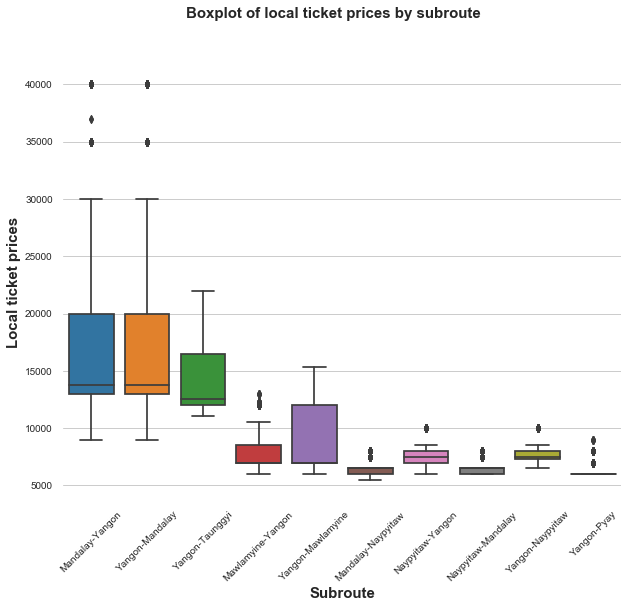


In [11]:
# checking bus_class and is_foreigner for 'Mandalay-Yangon'
agg_df.loc['Mandalay-Yangon']

sum_tix     avg_dur
trip_month is_foreigner bus_class                     
1          0            0            37681  573.609882
                        1            17319  529.781719
                        2              636  543.505618
           1            0             1156  557.130919
                        1              811  533.976834
...                                    ...         ...
11         0            0              102  587.500000
                        1              114  530.869565
                        2                2  540.000000
           1            0                2  480.000000
                        1               19  500.000000

[65 rows x 2 columns]

In [12]:
# checking bus_class and is_foreigner for 'Yangon-Pyay'
agg_df.loc['Yangon-Pyay']

sum_tix     avg_dur
trip_month is_foreigner bus_class                     
1          0            0            10577  446.708140
           1            0              166  446.320755
2          0            0            10712  447.040179
           1            0              197  448.524590
3          0            0            11794  445.698378
           1            0              178  441.028037
4          0            0             7972  446.264591
           1            0              153  448.750000
5          0            0            11811  445.618212
                        1              149  420.000000
           1            0              181  441.980198
                        1                3  420.000000
6          0            0            10262  447.083333
                        1             1181  356.842105
           1            0              229  450.458015
                        1               33  357.391304
7          0            0            10751  448.411103
                        1             1341  420.000000
           1            0              250  448.979592
                        1               59  420.000000
8          0            0             9631  451.665845
                        1             1187  420.000000
           1            0              238  451.020408
                        1               65  420.000000
9          0            0            11294  448.069861
                        1              948  420.000000
           1            0              266  454.642857
                        1               57  420.000000
10         0            0             9651  449.876881
                        1             1468  420.000000
           1            0              265  450.764331
                        1               76  420.000000
11         0            0               40  475.500000
                        1               10  420.000000
           1            0                2  420.000000

In [13]:
agg_df = agg_df.reset_index()

In [14]:
dummies = pd.get_dummies(agg_df['subroute_name'], prefix='sr')
dummies.head()

,sr_Mandalay-Naypyitaw,sr_Mandalay-Yangon,sr_Mawlamyine-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0


In [15]:
print(agg_df.shape)
agg_df = pd.concat([agg_df, dummies], axis=1)
print(agg_df.shape)
agg_df.head()

(470, 6)
(470, 16)


,subroute_name,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,sr_Mandalay-Naypyitaw,sr_Mandalay-Yangon,sr_Mawlamyine-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,Mandalay-Naypyitaw,1,0,0,10533,340.155595,1,0,0,0,0,0,0,0,0,0
1,Mandalay-Naypyitaw,1,0,1,1882,336.932862,1,0,0,0,0,0,0,0,0,0
2,Mandalay-Naypyitaw,1,1,0,337,343.373494,1,0,0,0,0,0,0,0,0,0
3,Mandalay-Naypyitaw,1,1,1,68,347.647059,1,0,0,0,0,0,0,0,0,0
4,Mandalay-Naypyitaw,2,0,0,9781,345.814587,1,0,0,0,0,0,0,0,0,0


In [16]:
agg_df.drop('subroute_name', axis=1, inplace=True)
agg_df.head()

,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,sr_Mandalay-Naypyitaw,sr_Mandalay-Yangon,sr_Mawlamyine-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,1,0,0,10533,340.155595,1,0,0,0,0,0,0,0,0,0
1,1,0,1,1882,336.932862,1,0,0,0,0,0,0,0,0,0
2,1,1,0,337,343.373494,1,0,0,0,0,0,0,0,0,0
3,1,1,1,68,347.647059,1,0,0,0,0,0,0,0,0,0
4,2,0,0,9781,345.814587,1,0,0,0,0,0,0,0,0,0


### heatmap

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5]), <a list of 15 Text xticklabel objects>)

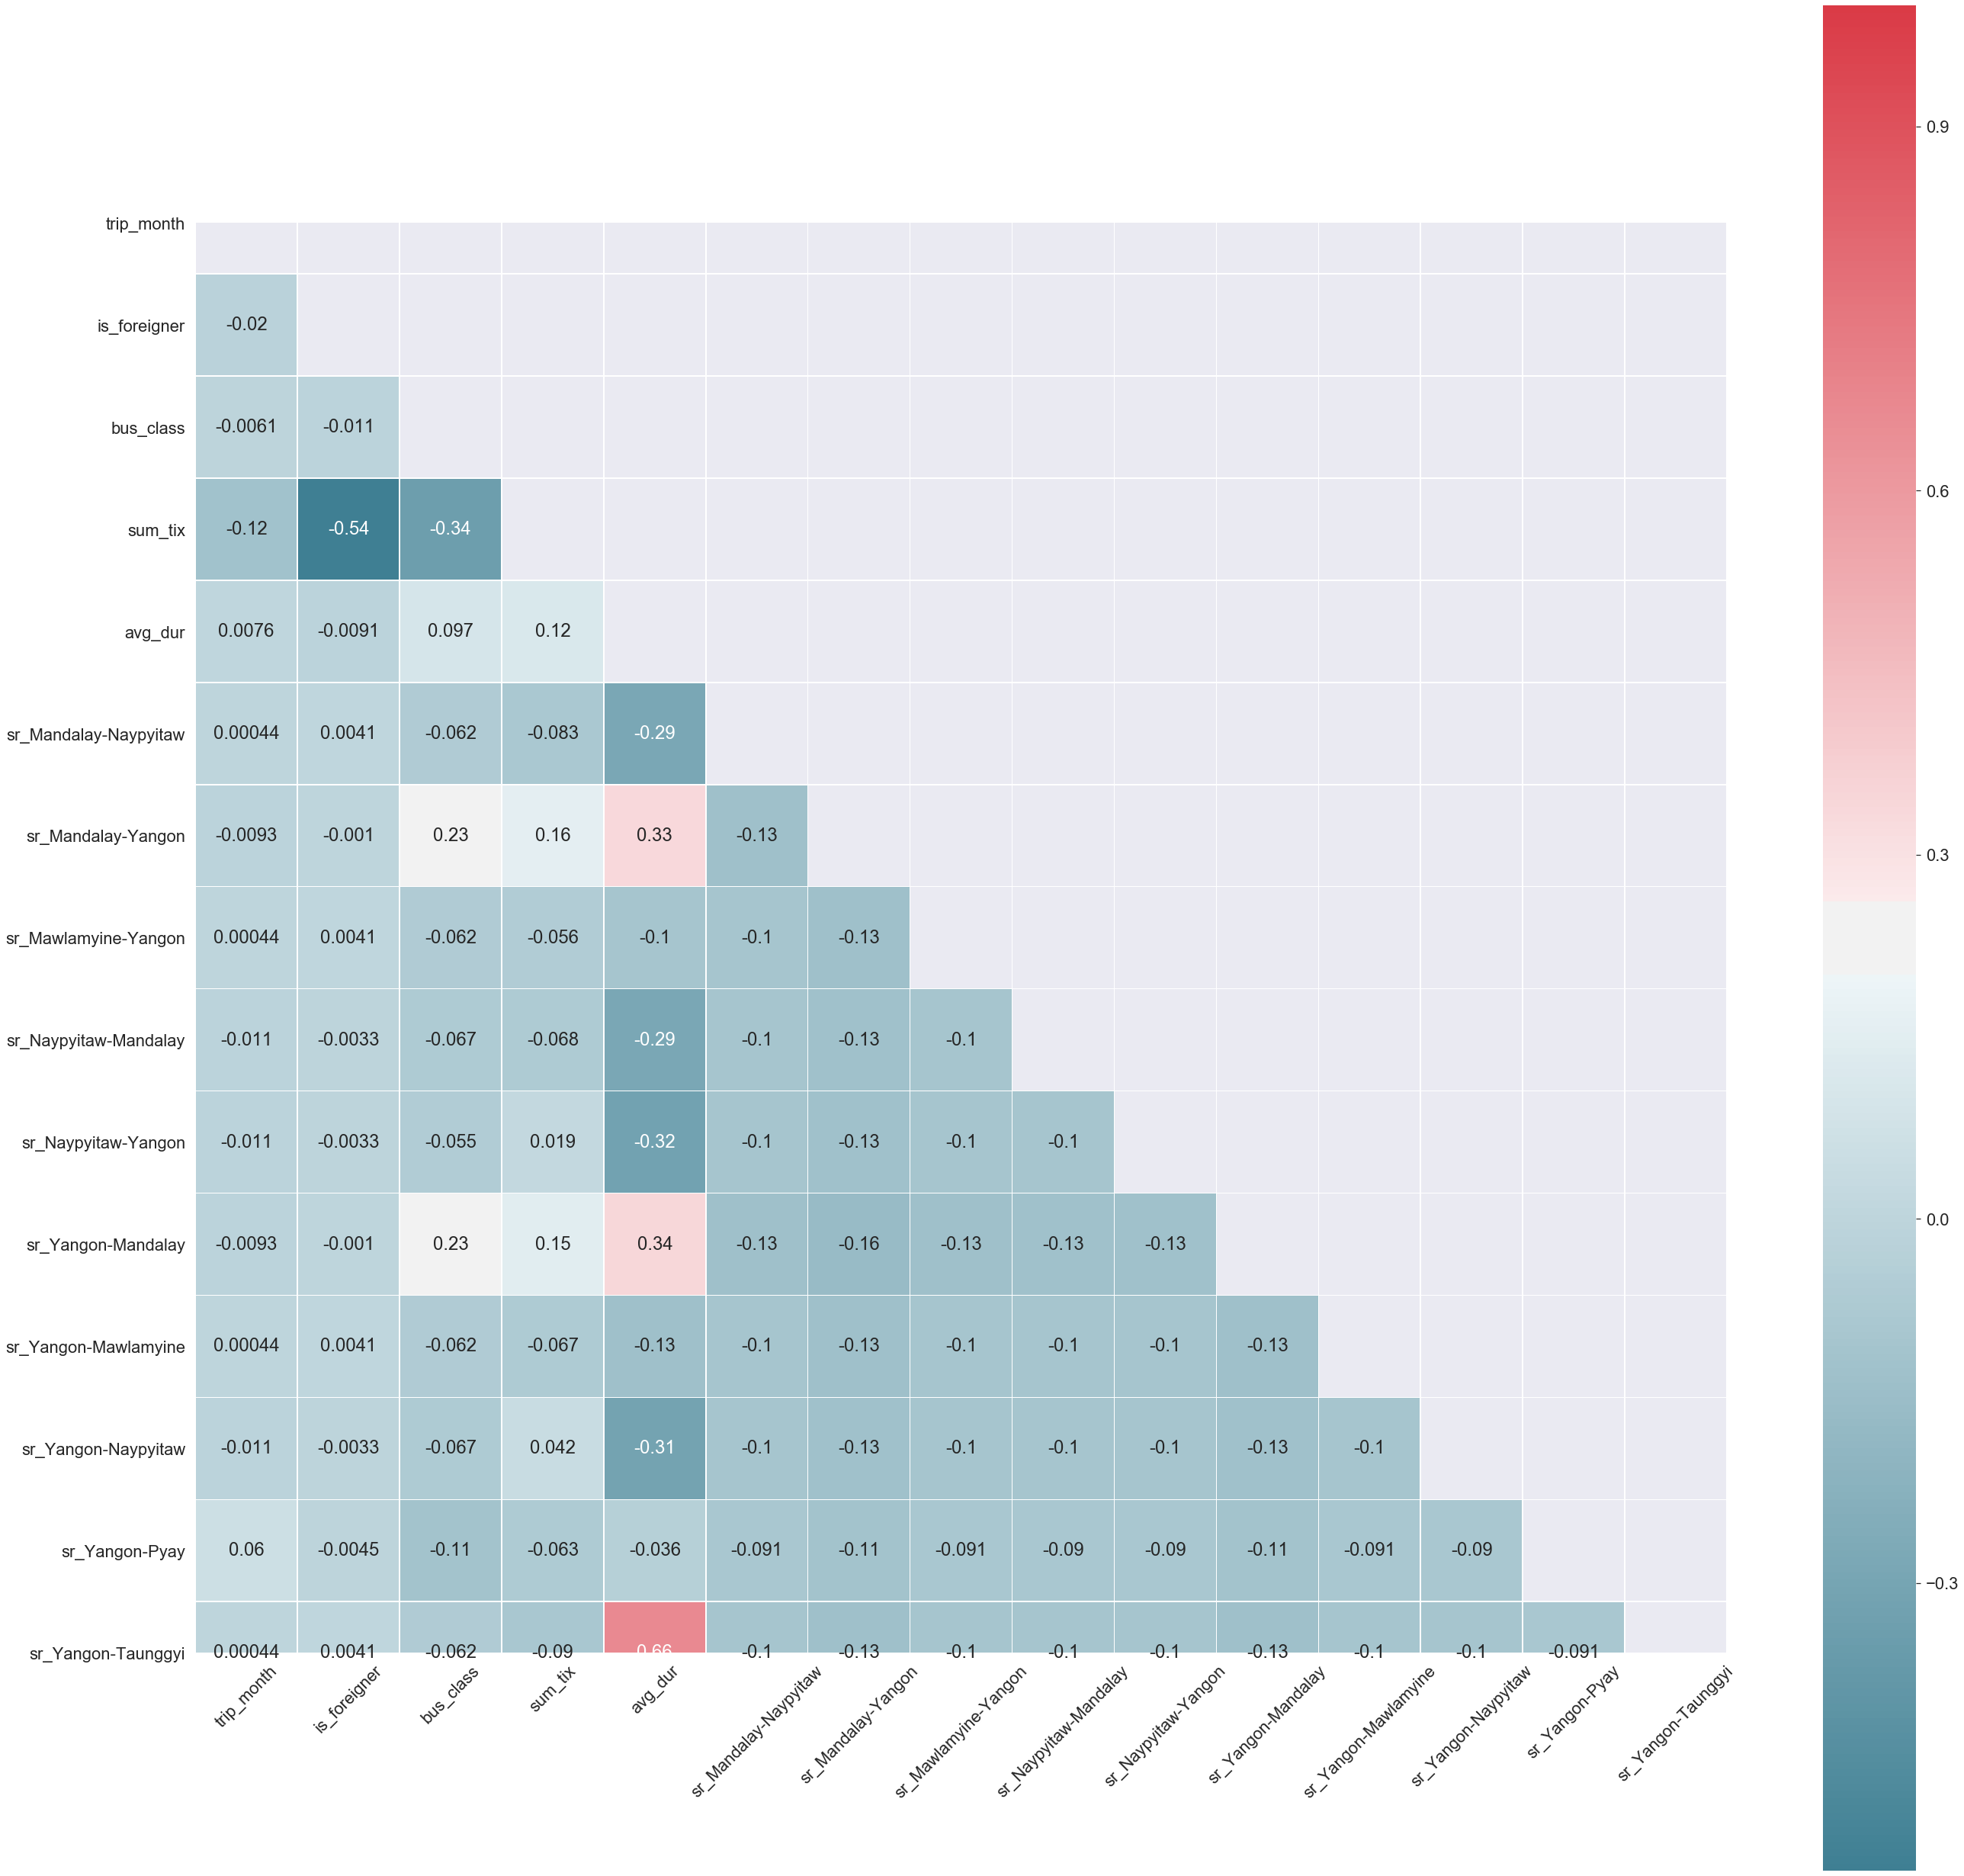

In [17]:
# lookng at the heatmap of our current dataset

corr = agg_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(45, 45))
sns.set(font_scale=2)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, square=True, linewidths=.5)
plt.xticks(rotation=45)


### features and target

In [18]:
features = agg_df.drop('sum_tix', axis=1)
print(features.shape)
features.head()

(470, 14)


,trip_month,is_foreigner,bus_class,avg_dur,sr_Mandalay-Naypyitaw,sr_Mandalay-Yangon,sr_Mawlamyine-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,1,0,0,340.155595,1,0,0,0,0,0,0,0,0,0
1,1,0,1,336.932862,1,0,0,0,0,0,0,0,0,0
2,1,1,0,343.373494,1,0,0,0,0,0,0,0,0,0
3,1,1,1,347.647059,1,0,0,0,0,0,0,0,0,0
4,2,0,0,345.814587,1,0,0,0,0,0,0,0,0,0


In [19]:
target = agg_df[['sum_tix']]
print(target.shape)

target.head()

(470, 1)


,sum_tix
0,10533
1,1882
2,337
3,68
4,9781


### train test split

In [20]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(features, target, test_size = 0.2, random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")



X shape is: (376, 14)
y shape is: (376, 1)

X_test shape is: (94, 14)
y_test shape is: (94, 1)


In [21]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42)

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (282, 14)
y_train shape is: (282, 1)

X_val shape is: (94, 14)
y_val shape is: (94, 1)


In [22]:
# creating a scores table to keep track of our model performance
scores_table = pd.DataFrame(columns = [
                            "model", 
                            "parameters", 
                            "features_size", 
                            "stratify", 
                            "comments", 
                            "train_score", 
                            "train_rmse",
                            "val_score", 
                            "val_rmse",
                            "test_score",
                            "test_rmse"
    
                                    ])

### Linear Regression - basic

In [23]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [24]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
Xtr_score = lr.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lr.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

X_train score is: 0.5718141384488639
X_train rmse is: 6083.760435034825


In [25]:
Xval_score = lr.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lr.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_val score is: 0.6544215008163285
X_val rmse is: 5294.935657030783


In [26]:
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [27]:
lr = LinearRegression()

lr.fit(X_sc, y)
X_test_score = lr.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lr.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.505886645198161
X_test rmse is: 5490.246558722044


In [28]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.5718141384488639
X_val score is: 0.6544215008163285
X_test score is: 0.505886645198161

X_train rmse is: 6083.760435034825
X_val rmse is: 5294.935657030783
X_test rmse is: 5490.246558722044


In [29]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, 
        "features_size": features.shape, 
        "stratify": None, 
        "comments": "" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.760435,0.654422,5294.935657,0.505887,5490.246559


### Linear Regression - with stratify

In [30]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(features, target, test_size = 0.2, random_state=42, stratify=features['trip_month'])
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")



X shape is: (376, 14)
y shape is: (376, 1)

X_test shape is: (94, 14)
y_test shape is: (94, 1)


In [31]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (282, 14)
y_train shape is: (282, 1)

X_val shape is: (94, 14)
y_val shape is: (94, 1)


In [32]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [33]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
Xtr_score = lr.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lr.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

X_train score is: 0.5703304747243295
X_train rmse is: 5385.333003920388


In [34]:
Xval_score = lr.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lr.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_val score is: 0.5639079619995295
X_val rmse is: 6796.5451802852795


In [35]:
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [36]:
lr = LinearRegression()

lr.fit(X_sc, y)
X_test_score = lr.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lr.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.5782967364811709
X_test rmse is: 6228.271036645669


In [37]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.5703304747243295
X_val score is: 0.5639079619995295
X_test score is: 0.5782967364811709

X_train rmse is: 5385.333003920388
X_val rmse is: 6796.5451802852795
X_test rmse is: 6228.271036645669


In [38]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, 
        "features_size": features.shape, 
        "stratify":"trip_month", 
        "comments": "" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.760435,0.654422,5294.935657,0.505887,5490.246559
1,Linear Regression,None,"(470, 14)",trip_month,,0.570330,5385.333004,0.563908,6796.545180,0.578297,6228.271037


### Lasso

We'll try Lasso to understand which are the key features.

In [39]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, random_state=42, verbose=1)
optimal_lasso.fit(X_train_sc, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

41.62987115771772


..............................................................................................................................................................................................................................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished


In [40]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_train_sc, y_train)

Xtr_score = lasso.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lasso.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

X_train score is: 0.5699399673790146
X_train rmse is: 5387.779691845651


In [41]:
Xval_score = lasso.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lasso.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)


X_val score is: 0.5596469564686941
X_val rmse is: 6829.668599306036


In [42]:
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [43]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_sc, y)
X_test_score = lasso.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lasso.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.5773502357963793
X_test rmse is: 6235.256705472232


In [44]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.5699399673790146
X_val score is: 0.5596469564686941
X_test score is: 0.5773502357963793

X_train rmse is: 5387.779691845651
X_val rmse is: 6829.668599306036
X_test rmse is: 6235.256705472232


In [45]:
scores_table = scores_table.append( { 
        "model": "Lasso", 
        "parameters": f"alpha: {optimal_lasso.alpha_}", 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.760435,0.654422,5294.935657,0.505887,5490.246559
1,Linear Regression,None,"(470, 14)",trip_month,,0.570330,5385.333004,0.563908,6796.545180,0.578297,6228.271037
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.569940,5387.779692,0.559647,6829.668599,0.577350,6235.256705


#### Lasso coefficients

In [46]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
1,is_foreigner,-4734.567789,4734.567789
2,bus_class,-4091.472486,4091.472486
5,sr_Mandalay-Yangon,2880.102215,2880.102215
9,sr_Yangon-Mandalay,2737.921905,2737.921905
0,trip_month,-1214.715077,1214.715077
8,sr_Naypyitaw-Yangon,594.855592,594.855592
11,sr_Yangon-Naypyitaw,591.720537,591.720537
12,sr_Yangon-Pyay,-201.939129,201.939129
10,sr_Yangon-Mawlamyine,-196.321188,196.321188
13,sr_Yangon-Taunggyi,-137.586325,137.586325


In [47]:
# taking a look at the features that have been zero-ed
lasso_coefs.loc[lasso_coefs["abs_coef"]==0]

,variable,coef,abs_coef
3,avg_dur,-0.0,0.0
4,sr_Mandalay-Naypyitaw,-0.0,0.0
6,sr_Mawlamyine-Yangon,0.0,0.0


#### removing zero-ed features

In [48]:
#creating a list of features to be dropped
zero_feat = [i for i in lasso_coefs.loc[lasso_coefs["abs_coef"]==0, "variable"]]
print(len(zero_feat))
zero_feat

3


['avg_dur', 'sr_Mandalay-Naypyitaw', 'sr_Mawlamyine-Yangon']

In [49]:
feat_dropped = features.drop(zero_feat, axis=1).copy()
feat_dropped

,trip_month,is_foreigner,bus_class,sr_Mandalay-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,1,0,0,0,0,0,0,0,0,0,0
1,1,0,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0,0
3,1,1,1,0,0,0,0,0,0,0,0
4,2,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
465,10,1,1,0,0,0,0,0,0,0,1
466,11,0,0,0,0,0,0,0,0,0,1
467,11,0,1,0,0,0,0,0,0,0,1
468,11,1,0,0,0,0,0,0,0,0,1


In [50]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(feat_dropped, target, test_size = 0.2, stratify=feat_dropped['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

X shape is: (376, 11)
y shape is: (376, 1)

X_test shape is: (94, 11)
y_test shape is: (94, 1)


In [51]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (282, 11)
y_train shape is: (282, 1)

X_val shape is: (94, 11)
y_val shape is: (94, 1)


In [52]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [53]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_train_sc, y_train)

Xtr_score = lasso.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)
Xtr_pred = lasso.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

Xval_score = lasso.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)
Xval_pred = lasso.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.5694717210075153
X_train rmse is: 5390.7119824206775

X_val score is: 0.5605902318587894
X_val rmse is: 6822.34979899395


In [54]:
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [55]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_sc, y)
X_test_score = lasso.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lasso.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.5773512440506292
X_test rmse is: 6235.249268193953


In [56]:
scores_table = scores_table.append( { 
        "model": "Lasso", 
        "parameters": f"alpha: {optimal_lasso.alpha_}", 
        "features_size": feat_dropped.shape, 
        "stratify": "trip_month", 
        "comments": "dropped zero-ed coeffs" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.760435,0.654422,5294.935657,0.505887,5490.246559
1,Linear Regression,None,"(470, 14)",trip_month,,0.570330,5385.333004,0.563908,6796.545180,0.578297,6228.271037
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.569940,5387.779692,0.559647,6829.668599,0.577350,6235.256705
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.711982,0.560590,6822.349799,0.577351,6235.249268


The model is performing pretty poorly so far. Ironically, it was a simple Linear Regression that had our highest test score. 

**What we can try**
* increasing the .groupby conditions to give us a larger data set
* feature engineering using polynomial features

## subroute_name, trip_month, is_foreigner, bus_class, depart_hour

In [57]:
model_df.head()

,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
22,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
23,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
24,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
25,18,1,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
26,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227


In [58]:
agg_df = model_df.groupby(['subroute_name', 'trip_month', 'is_foreigner', 'bus_class', 'depart_hour']).agg(
                                                                                                sum_tix = ('no_of_tickets', 'sum'),
                                                                                                avg_dur = ('duration_minutes', 'mean')
                                                                                                )

print(agg_df.shape)

agg_df.head()

(3322, 2)


sum_tix  \
subroute_name      trip_month is_foreigner bus_class depart_hour            
Mandalay-Naypyitaw 1          0            0         7                 35   
                                                     8               3008   
                                                     9                 59   
                                                     12              1806   
                                                     13               148   

                                                                     avg_dur  
subroute_name      trip_month is_foreigner bus_class depart_hour              
Mandalay-Naypyitaw 1          0            0         7            420.000000  
                                                     8            323.114272  
                                                     9            300.000000  
                                                     12           339.252336  
                                                     13           300.000000

In [59]:
agg_df = agg_df.reset_index()
agg_df.head(3)

,subroute_name,trip_month,is_foreigner,bus_class,depart_hour,sum_tix,avg_dur
0,Mandalay-Naypyitaw,1,0,0,7,35,420.000000
1,Mandalay-Naypyitaw,1,0,0,8,3008,323.114272
2,Mandalay-Naypyitaw,1,0,0,9,59,300.000000


In [60]:
def do_dummies(df):
    print("dummies")
    dummies = pd.get_dummies(df['subroute_name'], prefix='sr')
    display(dummies.head())
    print()
    
    print(f"shape before one-hot-encoding: {df.shape}")
    df = pd.concat([df, dummies], axis=1)
    df.drop('subroute_name', axis=1, inplace=True)
    print(f"shape after one-hot-encoding: {df.shape}")
    
    display(df.head())
    
    return df

In [61]:
agg_df = do_dummies(agg_df)

dummies


,sr_Mandalay-Naypyitaw,sr_Mandalay-Yangon,sr_Mawlamyine-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,0,0,0,0,0



shape before one-hot-encoding: (3322, 7)
shape after one-hot-encoding: (3322, 16)


,trip_month,is_foreigner,bus_class,depart_hour,sum_tix,avg_dur,sr_Mandalay-Naypyitaw,sr_Mandalay-Yangon,sr_Mawlamyine-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,1,0,0,7,35,420.000000,1,0,0,0,0,0,0,0,0,0
1,1,0,0,8,3008,323.114272,1,0,0,0,0,0,0,0,0,0
2,1,0,0,9,59,300.000000,1,0,0,0,0,0,0,0,0,0
3,1,0,0,12,1806,339.252336,1,0,0,0,0,0,0,0,0,0
4,1,0,0,13,148,300.000000,1,0,0,0,0,0,0,0,0,0


### features and target

In [62]:
features = agg_df.drop('sum_tix', axis=1)
print("features:", features.shape)
display(features.head())

target = agg_df[['sum_tix']]
print("target:", target.shape)
display(target.head())

features: (3322, 15)


,trip_month,is_foreigner,bus_class,depart_hour,avg_dur,sr_Mandalay-Naypyitaw,sr_Mandalay-Yangon,sr_Mawlamyine-Yangon,sr_Naypyitaw-Mandalay,sr_Naypyitaw-Yangon,sr_Yangon-Mandalay,sr_Yangon-Mawlamyine,sr_Yangon-Naypyitaw,sr_Yangon-Pyay,sr_Yangon-Taunggyi
0,1,0,0,7,420.000000,1,0,0,0,0,0,0,0,0,0
1,1,0,0,8,323.114272,1,0,0,0,0,0,0,0,0,0
2,1,0,0,9,300.000000,1,0,0,0,0,0,0,0,0,0
3,1,0,0,12,339.252336,1,0,0,0,0,0,0,0,0,0
4,1,0,0,13,300.000000,1,0,0,0,0,0,0,0,0,0


target: (3322, 1)


,sum_tix
0,35
1,3008
2,59
3,1806
4,148


### train test split

In [63]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(features, target, test_size = 0.2, stratify = features['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")



X shape is: (2657, 15)
y shape is: (2657, 1)

X_test shape is: (665, 15)
y_test shape is: (665, 1)


In [64]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=X['trip_month'], random_state=42)

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (1992, 15)
y_train shape is: (1992, 1)

X_val shape is: (665, 15)
y_val shape is: (665, 1)


In [65]:
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

### Linear Regression - basic

In [66]:
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
Xtr_score = lr.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)
Xtr_pred = lr.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)


Xval_score = lr.score(X_val_sc, y_val)
print()
print("X_val score is:", Xval_score)
Xval_pred = lr.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.23078620490453738
X_train rmse is: 1493.7072496237386

X_val score is: 0.2630235844068167
X_val rmse is: 1408.3681418162632


In [67]:
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [68]:
lr = LinearRegression()

lr.fit(X_sc, y)
X_test_score = lr.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lr.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.27155102948775967
X_test rmse is: 1563.881230004744


In [69]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.23078620490453738
X_val score is: 0.2630235844068167
X_test score is: 0.27155102948775967

X_train rmse is: 1493.7072496237386
X_val rmse is: 1408.3681418162632
X_test rmse is: 1563.881230004744


In [70]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "added depart_hour into groupby" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.760435,0.654422,5294.935657,0.505887,5490.246559
1,Linear Regression,None,"(470, 14)",trip_month,,0.570330,5385.333004,0.563908,6796.545180,0.578297,6228.271037
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.569940,5387.779692,0.559647,6829.668599,0.577350,6235.256705
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.711982,0.560590,6822.349799,0.577351,6235.249268
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.707250,0.263024,1408.368142,0.271551,1563.881230


### Lasso

In [71]:
optimal_lasso = LassoCV(n_alphas=500, cv=10, random_state=42, verbose=1)
optimal_lasso.fit(X_train_sc, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

0.614792306801603


...............[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    2.9s finished


In [72]:
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [73]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_train_sc, y_train)

Xtr_score = lasso.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)
Xtr_pred = lasso.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)


Xval_score = lasso.score(X_val_sc, y_val)
print()
print("X_val score is:", Xval_score)
Xval_pred = lasso.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.2308059207751758
X_train rmse is: 1493.6881067483744

X_val score is: 0.2622215467370037
X_val rmse is: 1409.1342838019405


In [74]:
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [75]:
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_sc, y)
X_test_score = lasso.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lasso.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.27131563762687605
X_test rmse is: 1564.1338868095145


In [76]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.2308059207751758
X_val score is: 0.2622215467370037
X_test score is: 0.27131563762687605

X_train rmse is: 1493.6881067483744
X_val rmse is: 1409.1342838019405
X_test rmse is: 1564.1338868095145


In [77]:
scores_table = scores_table.append( { 
        "model": "Lasso", 
        "parameters": f"alpha: {optimal_lasso.alpha_}", 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "added depart_hour into groupby" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
1,Linear Regression,None,"(470, 14)",trip_month,,0.570330,5385.333004,0.563908,6796.545180,0.578297,6228.271037
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.569940,5387.779692,0.559647,6829.668599,0.577350,6235.256705
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.711982,0.560590,6822.349799,0.577351,6235.249268
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.707250,0.263024,1408.368142,0.271551,1563.881230
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.688107,0.262222,1409.134284,0.271316,1564.133887


#### Lasso coefficients

In [78]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

lasso_coefs.head(20)

,variable,coef,abs_coef
1,is_foreigner,-644.235363,644.235363
6,sr_Mandalay-Yangon,493.430731,493.430731
10,sr_Yangon-Mandalay,489.178820,489.178820
4,avg_dur,-417.359828,417.359828
2,bus_class,-337.527499,337.527499
14,sr_Yangon-Taunggyi,252.115247,252.115247
0,trip_month,-119.797288,119.797288
3,depart_hour,105.131080,105.131080
8,sr_Naypyitaw-Mandalay,-59.660809,59.660809
7,sr_Mawlamyine-Yangon,52.813917,52.813917


In [79]:
# taking a look at the features that have been zero-ed
lasso_coefs.loc[lasso_coefs["abs_coef"]==0]

,variable,coef,abs_coef


## categorical depart_hour + Group By

Perhaps scores were bad because depart_hour is actually categorical rather than ordinal. (Or rather, there's a possibility that it's ordinal but we can't be sure.) 

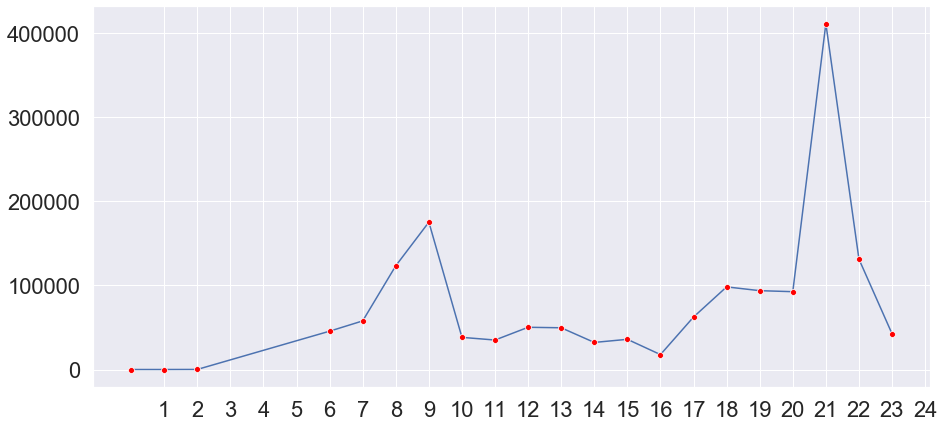

In [80]:
plt.figure(figsize=(15,7))
sns.lineplot(data=model_df['depart_hour'].value_counts().sort_index(), marker='o', markerfacecolor='red')

plt.xticks([ i for i in range(1,25)])

plt.show()

As we can see, buses are departing pretty much every hour of the day, except between 2-6am. From real world knowledge, we know that public transport infrastructure is still quite lacking in Burma, which might explain why there aren't really middle-of-the-night departures.

In [81]:
model_df.head(3)

,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
22,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
23,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
24,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227


In [82]:
agg_df = model_df.groupby(['subroute_name', 'trip_month', 'is_foreigner', 'bus_class', 'depart_hour']).agg(
                                                                                                sum_tix = ('no_of_tickets', 'sum'),
                                                                                                avg_dur = ('duration_minutes', 'mean')
                                                                                                )
print(agg_df.shape)
agg_df.head()

(3322, 2)


sum_tix  \
subroute_name      trip_month is_foreigner bus_class depart_hour            
Mandalay-Naypyitaw 1          0            0         7                 35   
                                                     8               3008   
                                                     9                 59   
                                                     12              1806   
                                                     13               148   

                                                                     avg_dur  
subroute_name      trip_month is_foreigner bus_class depart_hour              
Mandalay-Naypyitaw 1          0            0         7            420.000000  
                                                     8            323.114272  
                                                     9            300.000000  
                                                     12           339.252336  
                                                     13           300.000000

In [83]:
agg_df = agg_df.reset_index()
agg_df.head(3)

,subroute_name,trip_month,is_foreigner,bus_class,depart_hour,sum_tix,avg_dur
0,Mandalay-Naypyitaw,1,0,0,7,35,420.000000
1,Mandalay-Naypyitaw,1,0,0,8,3008,323.114272
2,Mandalay-Naypyitaw,1,0,0,9,59,300.000000


In [84]:
agg_df = pd.get_dummies(agg_df, columns=['depart_hour'])
print(agg_df.shape)
display(agg_df.head())
display(agg_df.tail())

(3322, 27)


,subroute_name,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_18,depart_hour_19,depart_hour_20,depart_hour_21,depart_hour_22,depart_hour_23
0,Mandalay-Naypyitaw,1,0,0,35,420.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Mandalay-Naypyitaw,1,0,0,3008,323.114272,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Mandalay-Naypyitaw,1,0,0,59,300.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Mandalay-Naypyitaw,1,0,0,1806,339.252336,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,Mandalay-Naypyitaw,1,0,0,148,300.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0


,subroute_name,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_18,depart_hour_19,depart_hour_20,depart_hour_21,depart_hour_22,depart_hour_23
3317,Yangon-Taunggyi,11,1,0,1,600.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3318,Yangon-Taunggyi,11,1,0,2,720.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
3319,Yangon-Taunggyi,11,1,1,5,600.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3320,Yangon-Taunggyi,11,1,1,2,600.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
3321,Yangon-Taunggyi,11,1,1,26,695.454545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [85]:
agg_df = pd.get_dummies(agg_df, columns=['subroute_name'])
print(agg_df.shape)
display(agg_df.head())
display(agg_df.tail())

(3322, 36)


,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_18,depart_hour_19,depart_hour_20,depart_hour_21,depart_hour_22,depart_hour_23,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,35,420.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,3008,323.114272,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,59,300.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,1806,339.252336,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,148,300.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_18,depart_hour_19,depart_hour_20,depart_hour_21,depart_hour_22,depart_hour_23,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
3317,11,1,0,1,600.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3318,11,1,0,2,720.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
3319,11,1,1,5,600.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3320,11,1,1,2,600.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3321,11,1,1,26,695.454545,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1


### features and target

In [86]:
features = agg_df.drop('sum_tix', axis=1)
print("features:", features.shape)
display(features.head())

target = agg_df[['sum_tix']]
print("target:", target.shape)
display(target.head())

features: (3322, 35)


,trip_month,is_foreigner,bus_class,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_18,depart_hour_19,depart_hour_20,depart_hour_21,depart_hour_22,depart_hour_23,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,420.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,323.114272,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,300.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,339.252336,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,300.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


target: (3322, 1)


,sum_tix
0,35
1,3008
2,59
3,1806
4,148


### train test split

In [87]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(features, target, test_size = 0.2, stratify=features['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

X shape is: (2657, 35)
y shape is: (2657, 1)

X_test shape is: (665, 35)
y_test shape is: (665, 1)


In [88]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (1992, 35)
y_train shape is: (1992, 1)

X_val shape is: (665, 35)
y_val shape is: (665, 1)


### Linear Regression - basic

In [89]:
# applying Standard Scaler on X_train and X_val
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [90]:
# linear regression on X_train_sc
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
Xtr_score = lr.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lr.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

#scoring X_val_sc
Xval_score = lr.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lr.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)


X_train score is: 0.2917767407026456
X_train rmse is: 1433.2668279203892

X_val score is: 0.2879492611791361
X_val rmse is: 1384.3466949912777


In [91]:
# applying Standard Scaler on overall train set and X_test
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [92]:
# applying Linear Regression on X_test
lr = LinearRegression()

lr.fit(X_sc, y)
X_test_score = lr.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)
X_test_pred = lr.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)


X_test score is: 0.3573247787868382
X_test rmse is: 1468.9262036238003


In [93]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)


X_train score is: 0.2917767407026456
X_val score is: 0.2879492611791361
X_test score is: 0.3573247787868382

X_train rmse is: 1433.2668279203892
X_val rmse is: 1384.3466949912777
X_test rmse is: 1468.9262036238003


In [94]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "Group By + one-hot-encoding on depart_hour" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.569940,5387.779692,0.559647,6829.668599,0.577350,6235.256705
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.711982,0.560590,6822.349799,0.577351,6235.249268
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.707250,0.263024,1408.368142,0.271551,1563.881230
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.688107,0.262222,1409.134284,0.271316,1564.133887
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.266828,0.287949,1384.346695,0.357325,1468.926204


### Lasso

In [95]:
# getting optimal_lasso again since our dataframe shape has changed

optimal_lasso = LassoCV(n_alphas=500, cv=10, random_state=42, verbose=1)
optimal_lasso.fit(X_train_sc, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

6.931586268943041


............................[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:    3.5s finished


In [96]:
# applying Standard Scaler on X_train and X_val
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)


In [97]:
# applying optimised Lasso
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_train_sc, y_train)

Xtr_score = lasso.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lasso.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

#scoring X_val_sc
Xval_score = lasso.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lasso.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.2910324588143731
X_train rmse is: 1434.019750397431

X_val score is: 0.2889797412362023
X_val rmse is: 1383.3446188187925


In [98]:
# applying Standard Scaler on overall train set and X_test
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [99]:
# applying Lasso on X_test
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_sc, y)
X_test_score = lasso.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lasso.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.35377336104641033
X_test rmse is: 1472.9792488431644


In [100]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.2910324588143731
X_val score is: 0.2889797412362023
X_test score is: 0.35377336104641033

X_train rmse is: 1434.019750397431
X_val rmse is: 1383.3446188187925
X_test rmse is: 1472.9792488431644


In [101]:
scores_table = scores_table.append( { 
        "model": "Lasso", 
        "parameters": optimal_lasso.alpha_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "Group By + one-hot-encoding on depart_hour" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.711982,0.560590,6822.349799,0.577351,6235.249268
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.707250,0.263024,1408.368142,0.271551,1563.881230
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.688107,0.262222,1409.134284,0.271316,1564.133887
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.266828,0.287949,1384.346695,0.357325,1468.926204
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.019750,0.288980,1383.344619,0.353773,1472.979249


### Random Forest Regressor v1

In [102]:
rf = RandomForestRegressor(random_state = 42)

In [103]:
rf_params = {
    'n_estimators': [10, 15, 20, 25, 50],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
}
gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1575 out of 1575 | elapsed:  3.5min finished


0.8221754649034569


{'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 50}

In [104]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [105]:
rf = gs.best_estimator_

In [106]:
rf.fit(X_train_sc, y_train)
Xtr_score = rf.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = rf.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)


print()
Xval_score = rf.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)
Xval_pred = rf.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.8999058873050881
X_train rmse is: 538.8231217323115

X_val score is: 0.8857822980540752
X_val rmse is: 554.4419808727729


In [107]:
rf.fit(X_sc, y)
X_test_score = rf.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = rf.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)


X_test score is: 0.7720081512018266
X_test rmse is: 874.9109669484137


In [108]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)


X_train score is: 0.8999058873050881
X_val score is: 0.8857822980540752
X_test score is: 0.7720081512018266

X_train rmse is: 538.8231217323115
X_val rmse is: 554.4419808727729
X_test rmse is: 874.9109669484137


In [109]:
scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "parameters": gs.best_params_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "Group By + one-hot-encoding on depart_hour" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.707250,0.263024,1408.368142,0.271551,1563.881230
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.688107,0.262222,1409.134284,0.271316,1564.133887
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.266828,0.287949,1384.346695,0.357325,1468.926204
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.019750,0.288980,1383.344619,0.353773,1472.979249
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823122,0.885782,554.441981,0.772008,874.910967


### Random Forest Regressor v2

In [110]:
# rf_params = {
#     'n_estimators': [10, 15, 20, 25],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'min_samples_split': [5, 10, 15, 20],
#     'min_samples_leaf': [2, 3, 4, 5, 6, 7],
# }

rf_params = {
    'n_estimators': [10, 15, 20, 25, 50],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
}

rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1575 out of 1575 | elapsed:  3.4min finished


0.8221754649034569


{'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 50}

In [111]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [112]:
rf = gs.best_estimator_

In [113]:
rf.fit(X_train_sc, y_train)
Xtr_score = rf.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = rf.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

Xval_score = rf.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = rf.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)


X_train score is: 0.8999058873050881
X_train rmse is: 538.8231217323115

X_val score is: 0.8857822980540752
X_val rmse is: 554.4419808727729


In [114]:
rf.fit(X_sc, y)
X_test_score = rf.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = rf.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.7720081512018266
X_test rmse is: 874.9109669484137


In [115]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.8999058873050881
X_val score is: 0.8857822980540752
X_test score is: 0.7720081512018266

X_train rmse is: 538.8231217323115
X_val rmse is: 554.4419808727729
X_test rmse is: 874.9109669484137


In [116]:
scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "parameters": gs.best_params_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "Group By + one-hot-encoding on depart_hour" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
scores_table.tail()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.688107,0.262222,1409.134284,0.271316,1564.133887
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.266828,0.287949,1384.346695,0.357325,1468.926204
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.019750,0.288980,1383.344619,0.353773,1472.979249
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823122,0.885782,554.441981,0.772008,874.910967
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823122,0.885782,554.441981,0.772008,874.910967


In [117]:
# this function allows us run calculations on whether the model performs better on test_score vs train_score
# this difference is calculated by test_score - train_score
# negative scores indicate the model is overfit to the train dataset
# positive scores indicate the model is underfit 
# the best scores will be displayed in green

def run_diff():
    scores_table["train_test_fit"] = scores_table["test_score"] - scores_table["train_score"]
    display(scores_table.style.highlight_max(color='lightgreen', subset=["test_score", "train_test_fit"]))

In [118]:
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


In terms of absolute test score, Random Forest Regressor seems to be doing the best, though there's some significant overfitting. 

### Lasso coefficients and dropping features with zero-ed coeffs

In [119]:
lasso_coefs = pd.DataFrame({'variable':X.columns,
                            'coef':lasso.coef_,
                            'abs_coef':np.abs(lasso.coef_)})

lasso_coefs.sort_values('abs_coef', inplace=True, ascending=False)

print(lasso_coefs.shape)
lasso_coefs.head(20)

(35, 3)


,variable,coef,abs_coef
1,is_foreigner,-643.877793,643.877793
30,subroute_name_Yangon-Mandalay,420.430677,420.430677
26,subroute_name_Mandalay-Yangon,404.869505,404.869505
22,depart_hour_21,387.945291,387.945291
2,bus_class,-323.126432,323.126432
3,avg_dur,-305.227210,305.227210
34,subroute_name_Yangon-Taunggyi,228.832860,228.832860
0,trip_month,-108.832243,108.832243
18,depart_hour_17,-56.889761,56.889761
10,depart_hour_9,44.690088,44.690088


In [120]:
# taking a look at the features that have been zero-ed
print(lasso_coefs.loc[lasso_coefs["abs_coef"]==0].shape)
lasso_coefs.loc[lasso_coefs["abs_coef"]==0]

(6, 3)


,variable,coef,abs_coef
20,depart_hour_19,0.0,0.0
19,depart_hour_18,0.0,0.0
23,depart_hour_22,0.0,0.0
24,depart_hour_23,0.0,0.0
31,subroute_name_Yangon-Mawlamyine,0.0,0.0
32,subroute_name_Yangon-Naypyitaw,-0.0,0.0


In [121]:
#creating a list of features to be dropped
zero_feat = [i for i in lasso_coefs.loc[lasso_coefs["abs_coef"]==0, "variable"]]
print(len(zero_feat))
zero_feat

6


['depart_hour_19',
 'depart_hour_18',
 'depart_hour_22',
 'depart_hour_23',
 'subroute_name_Yangon-Mawlamyine',
 'subroute_name_Yangon-Naypyitaw']

In [122]:
feat_dropped = features.drop(zero_feat, axis=1).copy()
feat_dropped

,trip_month,is_foreigner,bus_class,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_20,depart_hour_21,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,420.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
1,1,0,0,323.114272,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
2,1,0,0,300.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
3,1,0,0,339.252336,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,1,0,0,300.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,11,1,0,600.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3318,11,1,0,720.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1
3319,11,1,1,600.000000,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
3320,11,1,1,600.000000,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [123]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(feat_dropped, target, test_size = 0.2, stratify=feat_dropped['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

X shape is: (2657, 29)
y shape is: (2657, 1)

X_test shape is: (665, 29)
y_test shape is: (665, 1)


In [124]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (1992, 29)
y_train shape is: (1992, 1)

X_val shape is: (665, 29)
y_val shape is: (665, 1)


### Lasso v2

In [125]:
# getting optimal_lasso again since our dataframe shape has changed

optimal_lasso = LassoCV(n_alphas=500, cv=10, random_state=42, verbose=1)
optimal_lasso.fit(X_train_sc, y_train)

print(optimal_lasso.alpha_)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
.......................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

6.931586268943041


In [126]:
# applying Standard Scaler on X_train and X_val
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)


In [127]:
# applying optimised Lasso
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_train_sc, y_train)

Xtr_score = lasso.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lasso.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

#scoring X_val_sc
Xval_score = lasso.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lasso.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.29096851168637283
X_train rmse is: 1434.0844214659135

X_val score is: 0.289261318978111
X_val rmse is: 1383.07067611382


In [128]:
# applying Standard Scaler on overall train set and X_test
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [129]:
# applying Lasso on X_test
lasso = Lasso(alpha=optimal_lasso.alpha_)

lasso.fit(X_sc, y)
X_test_score = lasso.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lasso.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.35377313368569174
X_test rmse is: 1472.979507960919


In [130]:
scores_table = scores_table.append( { 
        "model": "Lasso", 
        "parameters": optimal_lasso.alpha_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "dropped zero-ed coeffs, Group By + one-hot-encoding on depart_hour" , 
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


### Random Forest Regressor v3

In [131]:
# rf_params = {
#     'n_estimators': [10, 15, 20, 25, 50],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'min_samples_split': [5, 10, 15, 20],
#     'min_samples_leaf': [2, 3, 4, 5, 6, 7],
# }

rf_params = {
    'n_estimators': [10, 15, 20, 50],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
}

rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8180704553140304


[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:  2.5min finished


{'max_depth': 8,
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 10}

In [132]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=4, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [133]:
rf = gs.best_estimator_

In [134]:
rf.fit(X_train_sc, y_train)
Xtr_score = rf.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = rf.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

Xval_score = rf.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = rf.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)


X_train score is: 0.8842523864004131
X_train rmse is: 579.426000834166

X_val score is: 0.8702216394330011
X_val rmse is: 591.004162006652


In [135]:
rf.fit(X_sc, y)
X_test_score = rf.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = rf.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)


X_test score is: 0.736430104859609
X_test rmse is: 940.7020753577054


In [136]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.8842523864004131
X_val score is: 0.8702216394330011
X_test score is: 0.736430104859609

X_train rmse is: 579.426000834166
X_val rmse is: 591.004162006652
X_test rmse is: 940.7020753577054


In [137]:
scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "parameters": gs.best_params_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "dropped zero-ed coeffs, Group By + one-hot-encoding on depart_hour" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


Random Forest still provies the best absolute score. 

And among our Random Forest Regressor models, the one that *did not* drop the features with zero-ed coeffs performed better both in terms of absolute score and overfit difference.

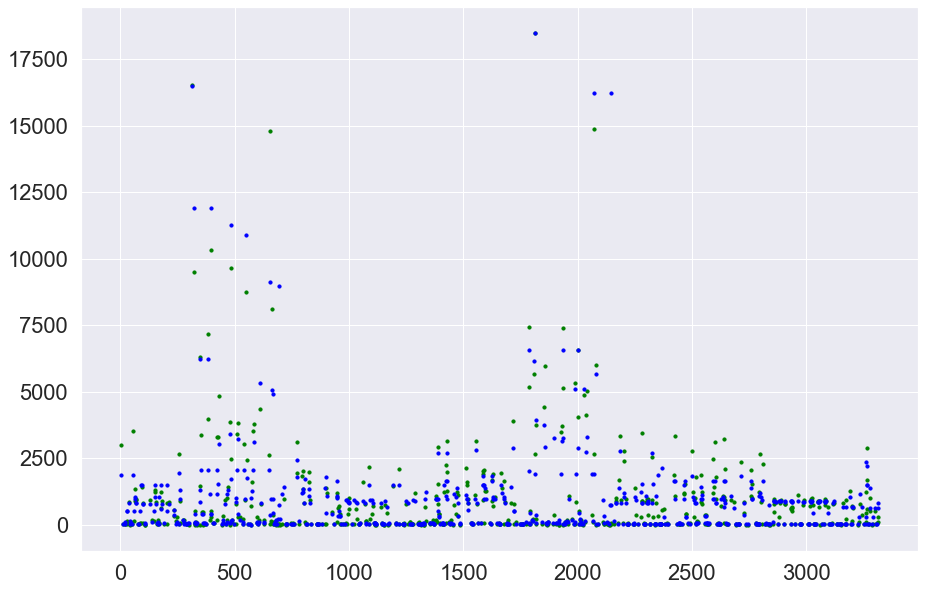

In [138]:
plt.figure(figsize=(15,10))
plt.scatter(X_test.index,y_test, color = 'green', s=10)
plt.scatter(X_test.index,X_test_pred, color='blue', s=10)

### Polynomial Features 

#### features and target

In [139]:
print(features.shape)
features.head()

(3322, 35)


,trip_month,is_foreigner,bus_class,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_18,depart_hour_19,depart_hour_20,depart_hour_21,depart_hour_22,depart_hour_23,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,420.000000,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,323.114272,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,300.000000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,1,0,0,339.252336,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,0,300.000000,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0


In [140]:
# Instantiate PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
display(poly)

PolynomialFeatures(degree=2, include_bias=False, interaction_only=False,
                   order='C')

In [141]:
# Create X_poly
features_poly = poly.fit_transform(features)
features_poly.shape

(3322, 665)

In [142]:
poly.get_feature_names(features.columns)

['trip_month',
 'is_foreigner',
 'bus_class',
 'avg_dur',
 'depart_hour_0',
 'depart_hour_1',
 'depart_hour_2',
 'depart_hour_6',
 'depart_hour_7',
 'depart_hour_8',
 'depart_hour_9',
 'depart_hour_10',
 'depart_hour_11',
 'depart_hour_12',
 'depart_hour_13',
 'depart_hour_14',
 'depart_hour_15',
 'depart_hour_16',
 'depart_hour_17',
 'depart_hour_18',
 'depart_hour_19',
 'depart_hour_20',
 'depart_hour_21',
 'depart_hour_22',
 'depart_hour_23',
 'subroute_name_Mandalay-Naypyitaw',
 'subroute_name_Mandalay-Yangon',
 'subroute_name_Mawlamyine-Yangon',
 'subroute_name_Naypyitaw-Mandalay',
 'subroute_name_Naypyitaw-Yangon',
 'subroute_name_Yangon-Mandalay',
 'subroute_name_Yangon-Mawlamyine',
 'subroute_name_Yangon-Naypyitaw',
 'subroute_name_Yangon-Pyay',
 'subroute_name_Yangon-Taunggyi',
 'trip_month^2',
 'trip_month is_foreigner',
 'trip_month bus_class',
 'trip_month avg_dur',
 'trip_month depart_hour_0',
 'trip_month depart_hour_1',
 'trip_month depart_hour_2',
 'trip_month depart_ho

In [143]:
poly_df = pd.DataFrame(features_poly, columns=poly.get_feature_names(features.columns))
print(poly_df.shape)
poly_df.head()

(3322, 665)


,trip_month,is_foreigner,bus_class,avg_dur,depart_hour_0,depart_hour_1,depart_hour_2,depart_hour_6,depart_hour_7,depart_hour_8,depart_hour_9,depart_hour_10,depart_hour_11,depart_hour_12,depart_hour_13,depart_hour_14,depart_hour_15,depart_hour_16,depart_hour_17,depart_hour_18,depart_hour_19,depart_hour_20,depart_hour_21,depart_hour_22,depart_hour_23,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi,trip_month^2,trip_month is_foreigner,trip_month bus_class,trip_month avg_dur,trip_month depart_hour_0,trip_month depart_hour_1,trip_month depart_hour_2,trip_month depart_hour_6,trip_month depart_hour_7,trip_month depart_hour_8,trip_month depart_hour_9,trip_month depart_hour_10,trip_month depart_hour_11,trip_month depart_hour_12,trip_month depart_hour_13,trip_month depart_hour_14,trip_month depart_hour_15,trip_month depart_hour_16,trip_month depart_hour_17,trip_month depart_hour_18,trip_month depart_hour_19,trip_month depart_hour_20,trip_month depart_hour_21,trip_month depart_hour_22,trip_month depart_hour_23,trip_month subroute_name_Mandalay-Naypyitaw,trip_month subroute_name_Mandalay-Yangon,trip_month subroute_name_Mawlamyine-Yangon,trip_month subroute_name_Naypyitaw-Mandalay,trip_month subroute_name_Naypyitaw-Yangon,trip_month subroute_name_Yangon-Mandalay,trip_month subroute_name_Yangon-Mawlamyine,trip_month subroute_name_Yangon-Naypyitaw,trip_month subroute_name_Yangon-Pyay,trip_month subroute_name_Yangon-Taunggyi,is_foreigner^2,is_foreigner bus_class,is_foreigner avg_dur,is_foreigner depart_hour_0,is_foreigner depart_hour_1,is_foreigner depart_hour_2,is_foreigner depart_hour_6,is_foreigner depart_hour_7,is_foreigner depart_hour_8,is_foreigner depart_hour_9,is_foreigner depart_hour_10,is_foreigner depart_hour_11,is_foreigner depart_hour_12,is_foreigner depart_hour_13,is_foreigner depart_hour_14,is_foreigner depart_hour_15,is_foreigner depart_hour_16,is_foreigner depart_hour_17,is_foreigner depart_hour_18,is_foreigner depart_hour_19,is_foreigner depart_hour_20,is_foreigner depart_hour_21,is_foreigner depart_hour_22,is_foreigner depart_hour_23,is_foreigner subroute_name_Mandalay-Naypyitaw,is_foreigner subroute_name_Mandalay-Yangon,is_foreigner subroute_name_Mawlamyine-Yangon,is_foreigner subroute_name_Naypyitaw-Mandalay,is_foreigner subroute_name_Naypyitaw-Yangon,is_foreigner subroute_name_Yangon-Mandalay,is_foreigner subroute_name_Yangon-Mawlamyine,is_foreigner subroute_name_Yangon-Naypyitaw,is_foreigner subroute_name_Yangon-Pyay,is_foreigner subroute_name_Yangon-Taunggyi,bus_class^2,bus_class avg_dur,bus_class depart_hour_0,bus_class depart_hour_1,bus_class depart_hour_2,bus_class depart_hour_6,bus_class depart_hour_7,bus_class depart_hour_8,bus_class depart_hour_9,bus_class depart_hour_10,bus_class depart_hour_11,bus_class depart_hour_12,bus_class depart_hour_13,bus_class depart_hour_14,bus_class depart_hour_15,bus_class depart_hour_16,bus_class depart_hour_17,bus_class depart_hour_18,bus_class depart_hour_19,bus_class depart_hour_20,bus_class depart_hour_21,bus_class depart_hour_22,bus_class depart_hour_23,bus_class subroute_name_Mandalay-Naypyitaw,bus_class subroute_name_Mandalay-Yangon,bus_class subroute_name_Mawlamyine-Yangon,bus_class subroute_name_Naypyitaw-Mandalay,bus_class subroute_name_Naypyitaw-Yangon,bus_class subroute_name_Yangon-Mandalay,bus_class subroute_name_Yangon-Mawlamyine,bus_class subroute_name_Yangon-Naypyitaw,bus_class subroute_name_Yangon-Pyay,bus_class subroute_name_Yangon-Taunggyi,avg_dur^2,avg_dur depart_hour_0,avg_dur depart_hour_1,avg_dur depart_hour_2,avg_dur depart_hour_6,avg_dur depart_hour_7,avg_dur depart_hour_8,avg_dur depart_hour_9,avg_dur depart_hour_10,avg_dur depart_hour_11,avg_dur depart_hour_12,avg_dur depart_hour_13,avg_dur depart_ho

#### train test split

In [144]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(poly_df, target, test_size = 0.2, stratify=poly_df['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")


X shape is: (2657, 665)
y shape is: (2657, 1)

X_test shape is: (665, 665)
y_test shape is: (665, 1)


In [145]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (1992, 665)
y_train shape is: (1992, 1)

X_val shape is: (665, 665)
y_val shape is: (665, 1)


#### Linear Regression

In [146]:
# applying Standard Scaler on X_train and X_val
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [147]:
# linear regression on X_train_sc
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
Xtr_score = lr.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lr.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

#scoring X_val_sc
Xval_score = lr.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lr.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.6933382910949417
X_train rmse is: 943.1303754665514

X_val score is: -4.919474563212141e+22
X_val rmse is: 363872099972150.0


In [148]:
# applying Standard Scaler on overall train set and X_test
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [149]:
# applying Linear Regression on X_test
lr = LinearRegression()

lr.fit(X_sc, y)
X_test_score = lr.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lr.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)


X_test score is: -1.9350802757341898e+22
X_test rmse is: 254890525903962.88


In [150]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.6933382910949417
X_val score is: -4.919474563212141e+22
X_test score is: -1.9350802757341898e+22

X_train rmse is: 943.1303754665514
X_val rmse is: 363872099972150.0
X_test rmse is: 254890525903962.88


In [151]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "Polynomial Features, Group By + one-hot-encoding on depart_hour" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


#### Random Forest Regressor

In [152]:
# rf_params = {
#     'n_estimators': [10, 15, 20, 25],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'min_samples_split': [5, 10, 15, 20],
#     'min_samples_leaf': [2, 3, 4, 5, 6, 7],
# }

rf_params = {
    'n_estimators': [10, 15, 20, 25, 50],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
}

rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1575 out of 1575 | elapsed: 19.6min finished


0.8106353507929601


{'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 10}

In [153]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=10,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [154]:
rf = gs.best_estimator_

In [155]:
rf.fit(X_train_sc, y_train)
Xtr_score = rf.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)
Xtr_pred = rf.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

Xval_score = rf.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)
Xval_pred = rf.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.8783151753223268
X_train rmse is: 594.1008408389598

X_val score is: 0.8266870754427594
X_val rmse is: 682.9751039323368


In [156]:
rf.fit(X_sc, y)
X_test_score = rf.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = rf.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.7370366414987418
X_test rmse is: 939.6190629988378


In [157]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.8783151753223268
X_val score is: 0.8266870754427594
X_test score is: 0.7370366414987418

X_train rmse is: 594.1008408389598
X_val rmse is: 682.9751039323368
X_test rmse is: 939.6190629988378


In [158]:
scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "parameters": gs.best_params_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "polynomial features, Group By + one-hot-encoding on depart_hour" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


## categorical depart_hour v2 + Group By

Maybe there were way too many features after we did get_dummies() on departure hour. Instead of encoding depart_hour by every single unique value, perhaps we can try binning it into three key time periods, then do one-hot-encoding on that.

### mapping `depart_hour` to `depart_period`

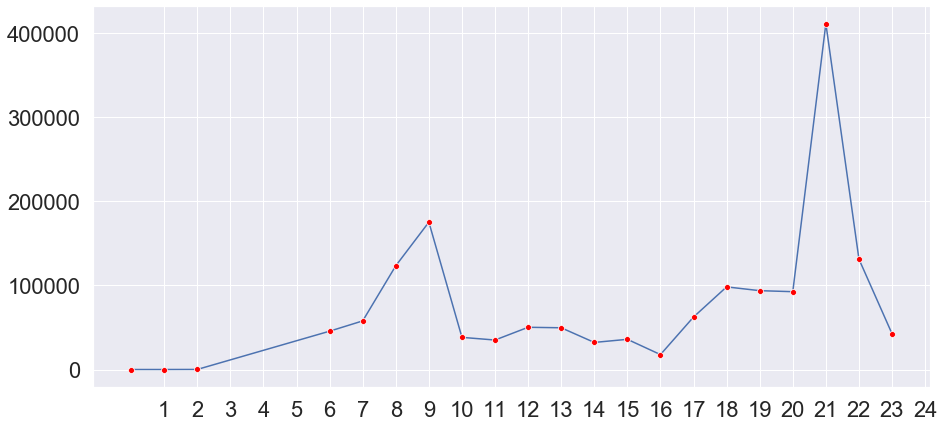

In [159]:
plt.figure(figsize=(15,7))
sns.lineplot(data=model_df['depart_hour'].value_counts().sort_index(), marker='o', markerfacecolor='red')

plt.xticks([ i for i in range(1,25)])
plt.xticks([ i for i in range(1,25)])

plt.show()

Based on the data above, we can try to bin `depart_hour` into these buckets:

* 'morn': 6 <= x < 12
* 'aft: 12 <= x < 18
* 'night': 18 <= x < 24 AND 0 <= x < 6

In [160]:
model_df.head()

,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
22,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
23,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
24,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
25,18,1,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227
26,18,0,1,0,Mandalay-Yangon,12800.0,20,5,540.0,8,33,3,227


In [161]:
def set_period(d_hour):
    if ((d_hour >= 6) and (d_hour < 12)):
        return 'morn'
    elif ((d_hour >= 12) and (d_hour < 18)):
        return "aft"
    else:
        return "night"

In [162]:
model_df['depart_period'] = model_df['depart_hour'].apply(set_period)

model_df[['depart_hour', 'depart_period']]

,depart_hour,depart_period
22,20,night
23,20,night
24,20,night
25,20,night
26,20,night
...,...,...
4321915,21,night
4321916,21,night
4321917,21,night
4321918,21,night


In [163]:
# checking the rows that should be mapped as 'morn' or 'aft'
model_df[model_df['depart_hour'] < 16]

,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear,depart_period
6165,20,0,3,1,Yangon-Mandalay,22000.0,9,18,540.0,1,1,1,1,morn
6173,20,0,1,1,Yangon-Mandalay,22000.0,9,18,540.0,1,1,1,1,morn
6177,20,0,2,1,Yangon-Mandalay,22000.0,9,18,540.0,1,1,1,1,morn
6178,20,0,1,1,Yangon-Mandalay,22000.0,9,18,540.0,1,1,1,1,morn
6183,20,0,2,1,Yangon-Mandalay,22000.0,9,18,540.0,1,1,1,1,morn
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4321188,10,0,2,0,Yangon-Naypyitaw,7000.0,14,19,300.0,10,42,6,293,aft
4321189,10,0,2,0,Yangon-Naypyitaw,7000.0,14,19,300.0,10,42,6,293,aft
4321190,10,0,1,0,Yangon-Naypyitaw,7000.0,14,19,300.0,10,42,6,293,aft
4321191,10,0,1,0,Yangon-Naypyitaw,7000.0,14,19,300.0,10,42,6,293,aft


In [164]:
# Group By

agg_df = model_df.groupby(['subroute_name', 'trip_month', 'is_foreigner', 'bus_class', 'depart_period']).agg(
                                                                                                sum_tix = ('no_of_tickets', 'sum'),
                                                                                                avg_dur = ('duration_minutes', 'mean')
                                                                                                )
print(agg_df.shape)
agg_df.head()

(1211, 2)


sum_tix  \
subroute_name      trip_month is_foreigner bus_class depart_period            
Mandalay-Naypyitaw 1          0            0         aft               4575   
                                                     morn              3102   
                                                     night             2856   
                                           1         aft                321   
                                                     morn               916   

                                                                       avg_dur  
subroute_name      trip_month is_foreigner bus_class depart_period              
Mandalay-Naypyitaw 1          0            0         aft            350.345572  
                                                     morn           323.768461  
                                                     night          340.823988  
                                           1         aft            420.000000  
                                                     morn           320.602941

In [165]:
agg_df = agg_df.reset_index()
agg_df.head(3)

,subroute_name,trip_month,is_foreigner,bus_class,depart_period,sum_tix,avg_dur
0,Mandalay-Naypyitaw,1,0,0,aft,4575,350.345572
1,Mandalay-Naypyitaw,1,0,0,morn,3102,323.768461
2,Mandalay-Naypyitaw,1,0,0,night,2856,340.823988


In [166]:
agg_df = pd.get_dummies(agg_df, columns=['depart_period'])
print(agg_df.shape)
display(agg_df.head())
display(agg_df.tail())

(1211, 9)


,subroute_name,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night
0,Mandalay-Naypyitaw,1,0,0,4575,350.345572,1,0,0
1,Mandalay-Naypyitaw,1,0,0,3102,323.768461,0,1,0
2,Mandalay-Naypyitaw,1,0,0,2856,340.823988,0,0,1
3,Mandalay-Naypyitaw,1,0,1,321,420.000000,1,0,0
4,Mandalay-Naypyitaw,1,0,1,916,320.602941,0,1,0


,subroute_name,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night
1206,Yangon-Taunggyi,11,0,1,343,679.090909,0,0,1
1207,Yangon-Taunggyi,11,1,0,2,750.000000,1,0,0
1208,Yangon-Taunggyi,11,1,0,3,660.000000,0,0,1
1209,Yangon-Taunggyi,11,1,1,5,600.000000,0,1,0
1210,Yangon-Taunggyi,11,1,1,28,687.500000,0,0,1


In [167]:
agg_df = pd.get_dummies(agg_df, columns=['subroute_name'])
print(agg_df.shape)
display(agg_df.head())
display(agg_df.tail())

(1211, 18)


,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,4575,350.345572,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,3102,323.768461,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,2856,340.823988,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,321,420.000000,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,1,916,320.602941,0,1,0,1,0,0,0,0,0,0,0,0,0


,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
1206,11,0,1,343,679.090909,0,0,1,0,0,0,0,0,0,0,0,0,1
1207,11,1,0,2,750.000000,1,0,0,0,0,0,0,0,0,0,0,0,1
1208,11,1,0,3,660.000000,0,0,1,0,0,0,0,0,0,0,0,0,1
1209,11,1,1,5,600.000000,0,1,0,0,0,0,0,0,0,0,0,0,1
1210,11,1,1,28,687.500000,0,0,1,0,0,0,0,0,0,0,0,0,1


#### saving fully processed 2019 dataset

In [274]:
agg_df.to_pickle("./data/test_2019.pkl")

### features and target

In [168]:
features = agg_df.drop('sum_tix', axis=1)
print("features:", features.shape)
display(features.head())

target = agg_df[['sum_tix']]
print("target:", target.shape)
display(target.head())

features: (1211, 17)


,trip_month,is_foreigner,bus_class,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,350.345572,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,323.768461,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,340.823988,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,420.000000,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,1,320.602941,0,1,0,1,0,0,0,0,0,0,0,0,0


target: (1211, 1)


,sum_tix
0,4575
1,3102
2,2856
3,321
4,916


### train test split

In [169]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(features, target, test_size = 0.2, stratify=features['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

X shape is: (968, 17)
y shape is: (968, 1)

X_test shape is: (243, 17)
y_test shape is: (243, 1)


In [170]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (726, 17)
y_train shape is: (726, 1)

X_val shape is: (242, 17)
y_val shape is: (242, 1)


### Linear Regression - basic

In [171]:
# applying Standard Scaler on X_train and X_val
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)


In [172]:
# linear regression on X_train_sc
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
Xtr_score = lr.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lr.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

#scoring X_val_sc
Xval_score = lr.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lr.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.4271847480249437
X_train rmse is: 3069.962633024702

X_val score is: 0.43366407051896005
X_val rmse is: 2687.393798564096


In [173]:
# applying Standard Scaler on overall train set and X_test
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)


In [174]:
# applying Linear Regression on X_test
lr = LinearRegression()

lr.fit(X_sc, y)
X_test_score = lr.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lr.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)


X_test score is: 0.4239490932500324
X_test rmse is: 3906.7997621259756


In [175]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.4271847480249437
X_val score is: 0.43366407051896005
X_test score is: 0.4239490932500324

X_train rmse is: 3069.962633024702
X_val rmse is: 2687.393798564096
X_test rmse is: 3906.7997621259756


In [176]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "Group By + one-hot-encoding on depart_period" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


### Random Forest Regressor

In [177]:
# rf_params = {
#     'n_estimators': [10, 15, 20, 25],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'min_samples_split': [5, 10, 15, 20],
#     'min_samples_leaf': [2, 3, 4, 5, 6, 7],

# }

rf_params = {
    'n_estimators': [10, 15, 20, 25],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
}

rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 252 candidates, totalling 1260 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8657521735012881


[Parallel(n_jobs=1)]: Done 1260 out of 1260 | elapsed:  1.3min finished


{'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 25}

In [178]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=25,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [179]:
rf = gs.best_estimator_

In [180]:
rf.fit(X_train_sc, y_train)
Xtr_score = rf.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)
Xtr_pred = rf.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

Xval_score = rf.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)
Xval_pred = rf.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)


X_train score is: 0.9570017566038866
X_train rmse is: 841.1068301944771

X_val score is: 0.8688614031000244
X_val rmse is: 1293.1816084856298


In [181]:
rf.fit(X_sc, y)
X_test_score = rf.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = rf.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.8936683921113535
X_test rmse is: 1678.5021847368262


In [182]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)


X_train score is: 0.9570017566038866
X_val score is: 0.8688614031000244
X_test score is: 0.8936683921113535

X_train rmse is: 841.1068301944771
X_val rmse is: 1293.1816084856298
X_test rmse is: 1678.5021847368262


In [183]:
scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "parameters": gs.best_params_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments":  "Group By + one-hot-encoding on depart_period" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


In [184]:
scores_table[scores_table['model'] == 'Random Forest Regressor']

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823122,0.885782,554.441981,0.772008,874.910967,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823122,0.885782,554.441981,0.772008,874.910967,-0.127898
11,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 4, 'min_s...","(3322, 35)",trip_month,"dropped zero-ed coeffs, Group By + one-hot-enc...",0.884252,579.426001,0.870222,591.004162,0.736430,940.702075,-0.147822
13,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...","(3322, 35)",trip_month,"polynomial features, Group By + one-hot-encodi...",0.878315,594.100841,0.826687,682.975104,0.737037,939.619063,-0.141279
15,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_s...","(1211, 17)",trip_month,Group By + one-hot-encoding on depart_period,0.957002,841.106830,0.868861,1293.181608,0.893668,1678.502185,-0.063333


This is our best model so far! It's still overfit, but it's the least overfitting among RF models.

### Polynomial Features 

#### features and target

In [185]:
print(features.shape)
features.head()

(1211, 17)


,trip_month,is_foreigner,bus_class,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,350.345572,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,323.768461,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,340.823988,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,420.000000,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,1,320.602941,0,1,0,1,0,0,0,0,0,0,0,0,0


In [186]:
# Instantiate PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
display(poly)

PolynomialFeatures(degree=2, include_bias=False, interaction_only=False,
                   order='C')

In [187]:
# Create X_poly
features_poly = poly.fit_transform(features)
features_poly.shape

(1211, 170)

In [188]:
poly.get_feature_names(features.columns)

['trip_month',
 'is_foreigner',
 'bus_class',
 'avg_dur',
 'depart_period_aft',
 'depart_period_morn',
 'depart_period_night',
 'subroute_name_Mandalay-Naypyitaw',
 'subroute_name_Mandalay-Yangon',
 'subroute_name_Mawlamyine-Yangon',
 'subroute_name_Naypyitaw-Mandalay',
 'subroute_name_Naypyitaw-Yangon',
 'subroute_name_Yangon-Mandalay',
 'subroute_name_Yangon-Mawlamyine',
 'subroute_name_Yangon-Naypyitaw',
 'subroute_name_Yangon-Pyay',
 'subroute_name_Yangon-Taunggyi',
 'trip_month^2',
 'trip_month is_foreigner',
 'trip_month bus_class',
 'trip_month avg_dur',
 'trip_month depart_period_aft',
 'trip_month depart_period_morn',
 'trip_month depart_period_night',
 'trip_month subroute_name_Mandalay-Naypyitaw',
 'trip_month subroute_name_Mandalay-Yangon',
 'trip_month subroute_name_Mawlamyine-Yangon',
 'trip_month subroute_name_Naypyitaw-Mandalay',
 'trip_month subroute_name_Naypyitaw-Yangon',
 'trip_month subroute_name_Yangon-Mandalay',
 'trip_month subroute_name_Yangon-Mawlamyine',
 'tr

In [189]:
poly_df = pd.DataFrame(features_poly, columns=poly.get_feature_names(features.columns))
print(poly_df.shape)
poly_df.head()

(1211, 170)


,trip_month,is_foreigner,bus_class,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi,trip_month^2,trip_month is_foreigner,trip_month bus_class,trip_month avg_dur,trip_month depart_period_aft,trip_month depart_period_morn,trip_month depart_period_night,trip_month subroute_name_Mandalay-Naypyitaw,trip_month subroute_name_Mandalay-Yangon,trip_month subroute_name_Mawlamyine-Yangon,trip_month subroute_name_Naypyitaw-Mandalay,trip_month subroute_name_Naypyitaw-Yangon,trip_month subroute_name_Yangon-Mandalay,trip_month subroute_name_Yangon-Mawlamyine,trip_month subroute_name_Yangon-Naypyitaw,trip_month subroute_name_Yangon-Pyay,trip_month subroute_name_Yangon-Taunggyi,is_foreigner^2,is_foreigner bus_class,is_foreigner avg_dur,is_foreigner depart_period_aft,is_foreigner depart_period_morn,is_foreigner depart_period_night,is_foreigner subroute_name_Mandalay-Naypyitaw,is_foreigner subroute_name_Mandalay-Yangon,is_foreigner subroute_name_Mawlamyine-Yangon,is_foreigner subroute_name_Naypyitaw-Mandalay,is_foreigner subroute_name_Naypyitaw-Yangon,is_foreigner subroute_name_Yangon-Mandalay,is_foreigner subroute_name_Yangon-Mawlamyine,is_foreigner subroute_name_Yangon-Naypyitaw,is_foreigner subroute_name_Yangon-Pyay,is_foreigner subroute_name_Yangon-Taunggyi,bus_class^2,bus_class avg_dur,bus_class depart_period_aft,bus_class depart_period_morn,bus_class depart_period_night,bus_class subroute_name_Mandalay-Naypyitaw,bus_class subroute_name_Mandalay-Yangon,bus_class subroute_name_Mawlamyine-Yangon,bus_class subroute_name_Naypyitaw-Mandalay,bus_class subroute_name_Naypyitaw-Yangon,bus_class subroute_name_Yangon-Mandalay,bus_class subroute_name_Yangon-Mawlamyine,bus_class subroute_name_Yangon-Naypyitaw,bus_class subroute_name_Yangon-Pyay,bus_class subroute_name_Yangon-Taunggyi,avg_dur^2,avg_dur depart_period_aft,avg_dur depart_period_morn,avg_dur depart_period_night,avg_dur subroute_name_Mandalay-Naypyitaw,avg_dur subroute_name_Mandalay-Yangon,avg_dur subroute_name_Mawlamyine-Yangon,avg_dur subroute_name_Naypyitaw-Mandalay,avg_dur subroute_name_Naypyitaw-Yangon,avg_dur subroute_name_Yangon-Mandalay,avg_dur subroute_name_Yangon-Mawlamyine,avg_dur subroute_name_Yangon-Naypyitaw,avg_dur subroute_name_Yangon-Pyay,avg_dur subroute_name_Yangon-Taunggyi,depart_period_aft^2,depart_period_aft depart_period_morn,depart_period_aft depart_period_night,depart_period_aft subroute_name_Mandalay-Naypyitaw,depart_period_aft subroute_name_Mandalay-Yangon,depart_period_aft subroute_name_Mawlamyine-Yangon,depart_period_aft subroute_name_Naypyitaw-Mandalay,depart_period_aft subroute_name_Naypyitaw-Yangon,depart_period_aft subroute_name_Yangon-Mandalay,depart_period_aft subroute_name_Yangon-Mawlamyine,depart_period_aft subroute_name_Yangon-Naypyitaw,depart_period_aft subroute_name_Yangon-Pyay,depart_period_aft subroute_name_Yangon-Taunggyi,depart_period_morn^2,depart_period_morn depart_period_night,depart_period_morn subroute_name_Mandalay-Naypyitaw,depart_period_morn subroute_name_Mandalay-Yangon,depart_period_morn subroute_name_Mawlamyine-Yangon,depart_period_morn subroute_name_Naypyitaw-Mandalay,depart_period_morn subroute_name_Naypyitaw-Yangon,depart_period_morn subroute_name_Yangon-Mandalay,depart_period_morn subroute_name_Yangon-Mawlamyine,depart_period_morn subroute_name_Yangon-Naypyitaw,depart_period_morn subroute_name_Yangon-Pyay,depart_period_morn subroute_name_Yangon-Taunggyi,depart_period_night^2,depart_period_night subroute_name_Mandalay-Naypyitaw,depart_period_night subroute_name_Mandalay-Yangon,depart_period_night subroute_name_Mawlamyine-Yangon,depart_period_night subroute_name_Naypyitaw-Mandalay,depart_period_night subroute_name_Naypy

#### train test split

In [190]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(poly_df, target, test_size = 0.2, stratify=poly_df['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")


X shape is: (968, 170)
y shape is: (968, 1)

X_test shape is: (243, 170)
y_test shape is: (243, 1)


In [191]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")

X_train shape is: (726, 170)
y_train shape is: (726, 1)

X_val shape is: (242, 170)
y_val shape is: (242, 1)


#### Linear Regression

In [192]:
# applying Standard Scaler on X_train and X_val
ss = StandardScaler()

X_train_sc = ss.fit_transform(X_train)
X_val_sc = ss.transform(X_val)

In [193]:
# linear regression on X_train_sc
lr = LinearRegression()

lr.fit(X_train_sc, y_train)
Xtr_score = lr.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = lr.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

#scoring X_val_sc
Xval_score = lr.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)

Xval_pred = lr.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.8078044846816428
X_train rmse is: 1778.2688771042208

X_val score is: 0.7432778164397371
X_val rmse is: 1809.364029258381


In [194]:
# applying Standard Scaler on overall train set and X_test
ss = StandardScaler()

X_sc = ss.fit_transform(X)
X_test_sc = ss.transform(X_test)

In [195]:
# applying Linear Regression on X_test
lr = LinearRegression()

lr.fit(X_sc, y)
X_test_score = lr.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = lr.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)


X_test score is: 0.7173887627825037
X_test rmse is: 2736.436870746909


In [196]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.8078044846816428
X_val score is: 0.7432778164397371
X_test score is: 0.7173887627825037

X_train rmse is: 1778.2688771042208
X_val rmse is: 1809.364029258381
X_test rmse is: 2736.436870746909


In [197]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments": "Polynomial Features, Group By + one-hot-encoding on depart_period" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


#### Random Forest Regressor

In [198]:
# rf_params = {
#     'n_estimators': [10, 15, 20, 25],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'min_samples_split': [5, 10, 15, 20],
#     'min_samples_leaf': [2, 3, 4, 5, 6, 7],

# }

rf_params = {
    'n_estimators': [10, 15, 20, 25, 50],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
}

rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(X_train_sc, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1575 out of 1575 | elapsed:  4.4min finished


0.8687214595758458


{'max_depth': 8,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 50}

In [199]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=8,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=50,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [200]:
rf = gs.best_estimator_

In [201]:
rf.fit(X_train_sc, y_train)
Xtr_score = rf.score(X_train_sc, y_train)
print("X_train score is:", Xtr_score)
Xtr_pred = rf.predict(X_train_sc)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

Xval_score = rf.score(X_val_sc, y_val)
print("X_val score is:", Xval_score)
Xval_pred = rf.predict(X_val_sc)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)


X_train score is: 0.9580419164275353
X_train rmse is: 830.8710452111245

X_val score is: 0.9068561569713992
X_val rmse is: 1089.861545869759


In [202]:
rf.fit(X_sc, y)
X_test_score = rf.score(X_test_sc, y_test)
print("X_test score is:", X_test_score)

X_test_pred = rf.predict(X_test_sc)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)


X_test score is: 0.775196244015314
X_test rmse is: 2440.576930836407


In [203]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)


X_train score is: 0.9580419164275353
X_val score is: 0.9068561569713992
X_test score is: 0.775196244015314

X_train rmse is: 830.8710452111245
X_val rmse is: 1089.861545869759
X_test rmse is: 2440.576930836407


In [204]:
scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "parameters": gs.best_params_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments":  "Polynomial features, Group By + one-hot-encoding on depart_period" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


Seems like across the board

* Random Forest Regressor gives the best absolute value
* Models that use polynomial features and Lasso aren't so useful.

(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5, 14.5, 15.5, 16.5, 17.5]),
 <a list of 18 Text xticklabel objects>)

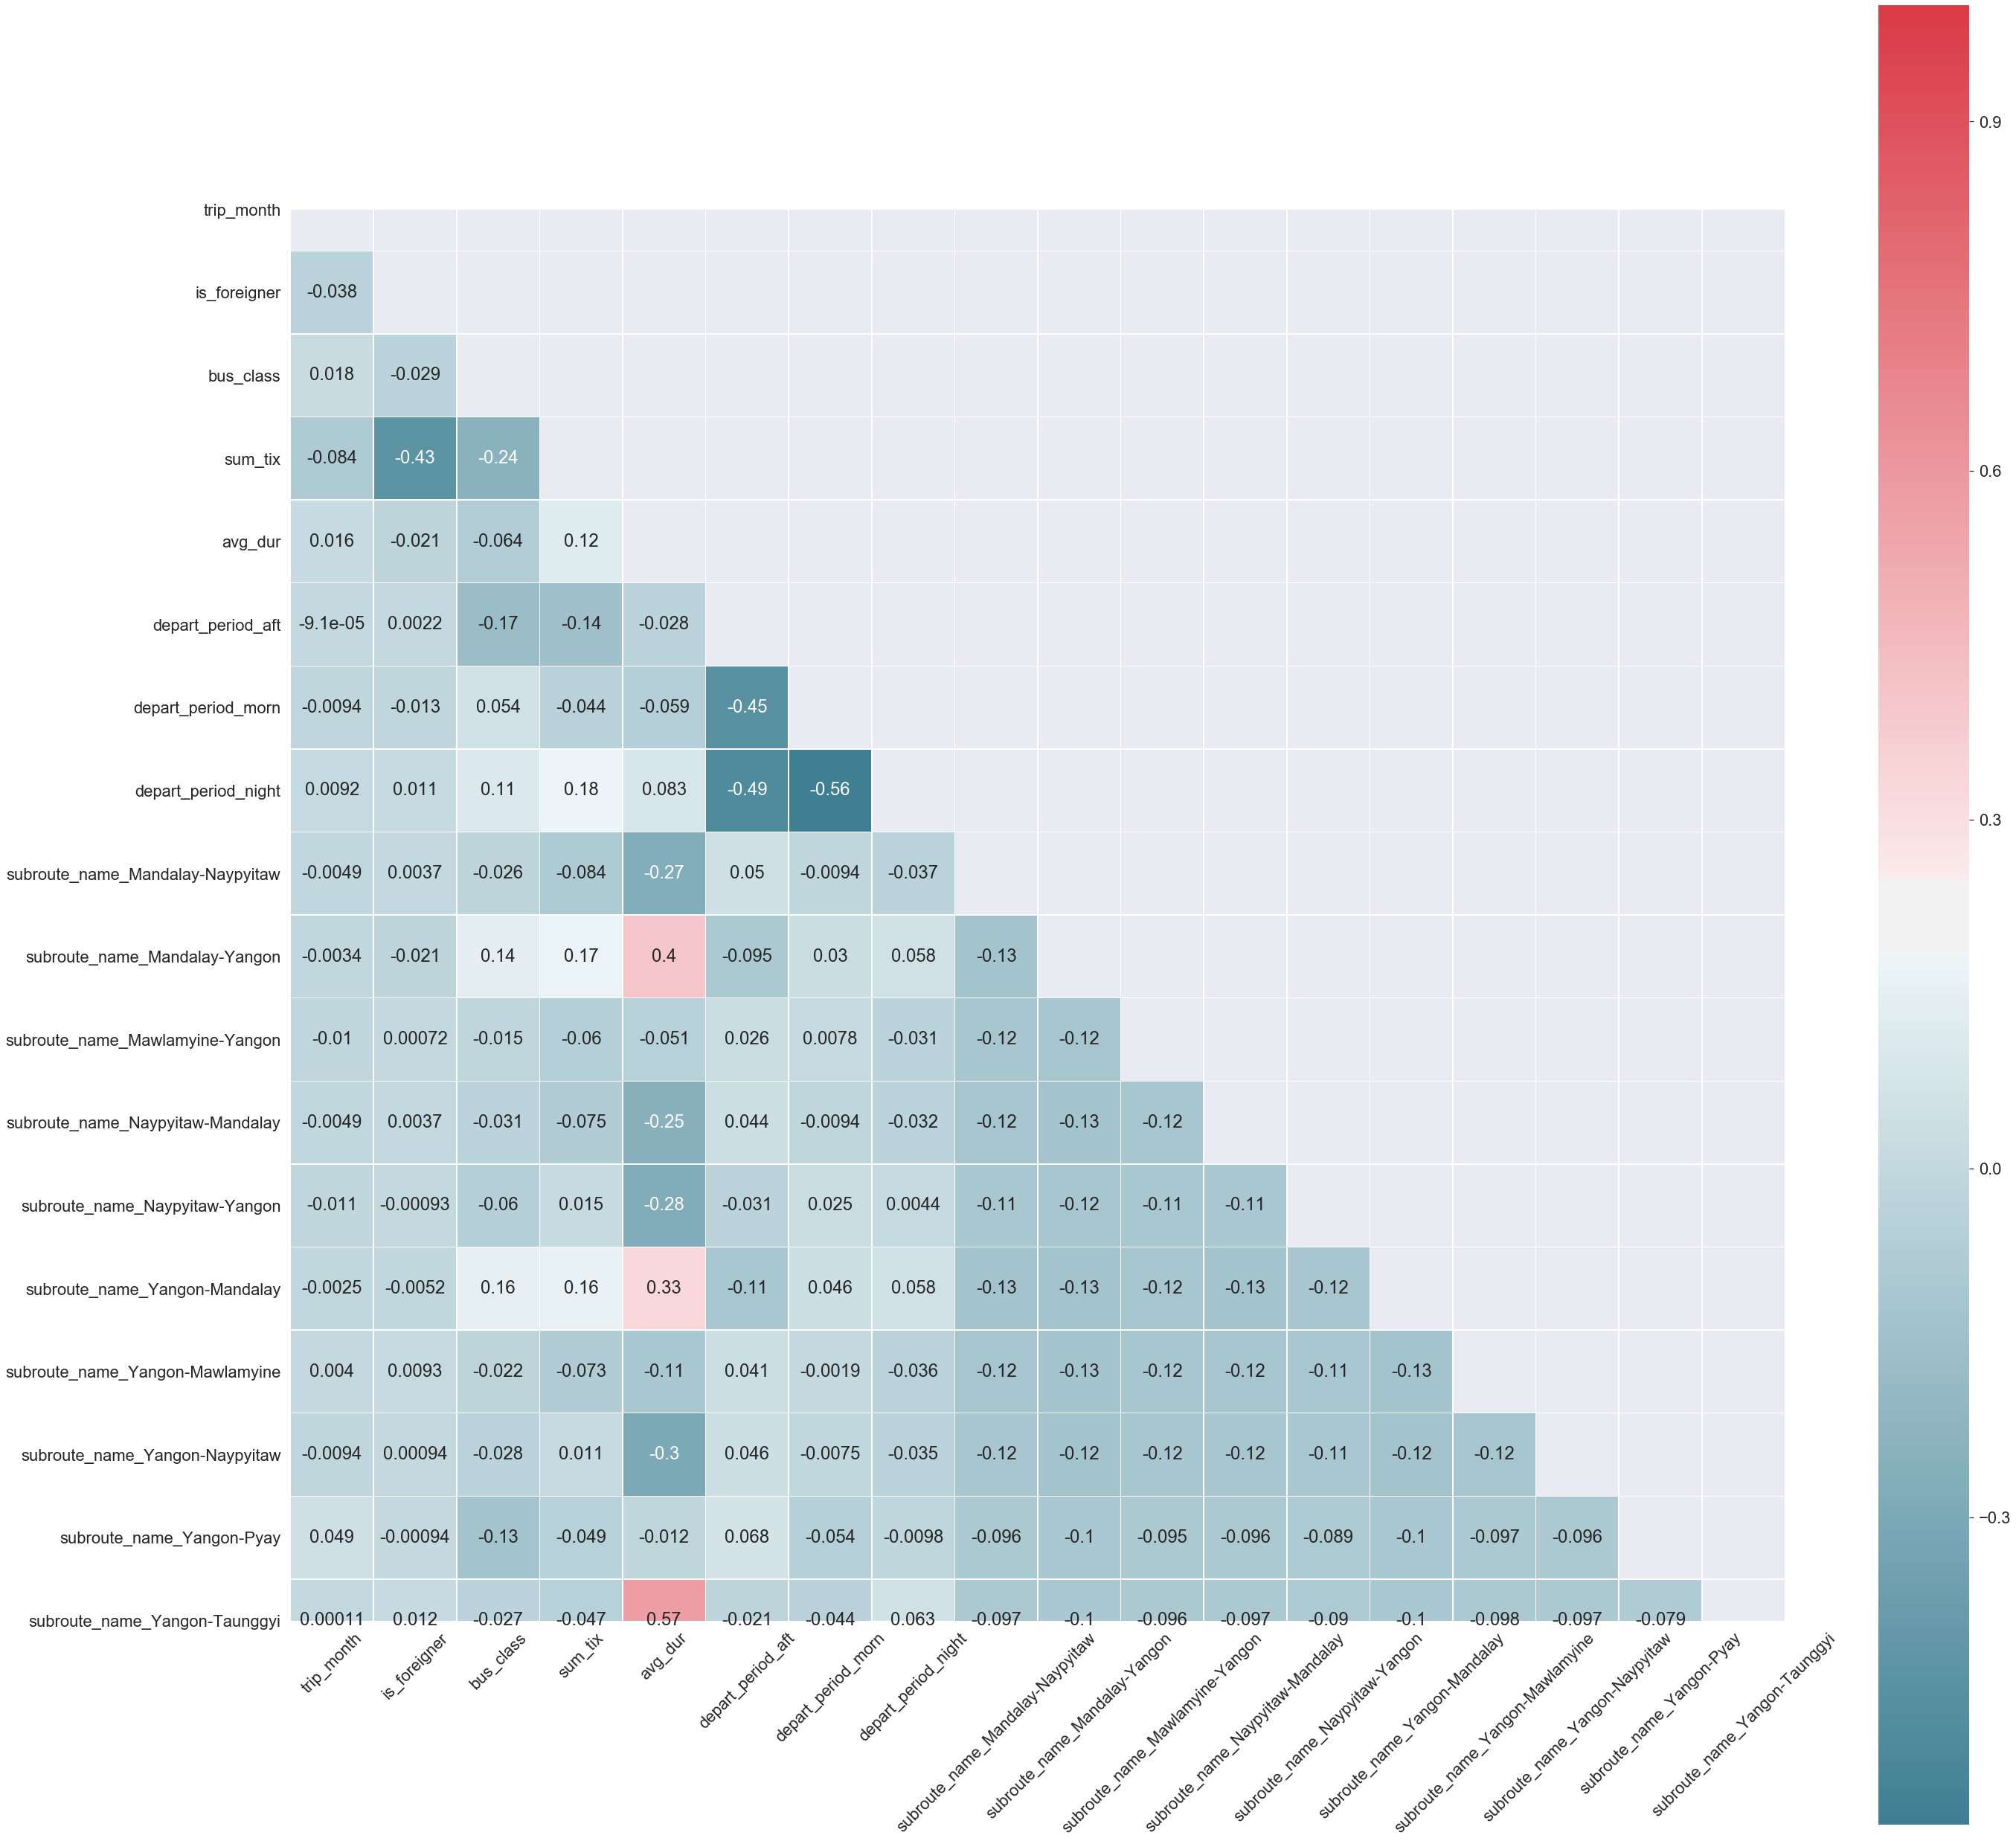

In [205]:
# lookng at the heatmap of our current dataset

corr = agg_df.corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

plt.figure(figsize=(45, 45))
sns.set(font_scale=2)

sns.heatmap(corr, annot=True, mask=mask, cmap=cmap, square=True, linewidths=.5)
plt.xticks(rotation=45)


# Model interpretation

Now, we want to try to understand the key predictors using Decision Trees.

## train test split

we need to repeat this step so that we're not stuck with the features from the post-polynomial features data

In [206]:
# preparing train and test set
X, X_test, y, y_test = train_test_split(features, target, test_size = 0.2, stratify=features['trip_month'], random_state=42)
print(f"X shape is: {X.shape}")
print(f"y shape is: {y.shape}")
print()

print(f"X_test shape is: {X_test.shape}")
print(f"y_test shape is: {y_test.shape}")

X shape is: (968, 17)
y shape is: (968, 1)

X_test shape is: (243, 17)
y_test shape is: (243, 1)


In [207]:
# preparing X_train and X_val set
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=42, stratify=X['trip_month'])

print(f"X_train shape is: {X_train.shape}")
print(f"y_train shape is: {y_train.shape}")
print()

print(f"X_val shape is: {X_val.shape}")
print(f"y_val shape is: {y_val.shape}")


X_train shape is: (726, 17)
y_train shape is: (726, 1)

X_val shape is: (242, 17)
y_val shape is: (242, 1)


## Decision Tree Regressor

In [208]:
# dt_params = {
#         'max_depth': [2, 3, 4, 5, 6, 7, 8],
#         'min_samples_split': [2, 3, 4, 5],
#         'min_samples_leaf': [2, 3, 4, 5]
# }

dt_params = {
        'max_depth': [2, 3, 4, 5, 6, 7, 8],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [3, 4, 5],
}


dt = DecisionTreeRegressor()

gs = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose=True)
gs.fit(X_train, y_train)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.8427678669005662


[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    3.7s finished


{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5}

In [209]:
dt = gs.best_estimator_

In [210]:
dt.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [211]:
Xtr_score = dt.score(X_train, y_train)
print("X_train score is:", Xtr_score)

Xtr_pred = dt.predict(X_train)
Xtr_rmse = np.sqrt(metrics.mean_squared_error(y_train, Xtr_pred))
print("X_train rmse is:", Xtr_rmse)

print()

Xval_score = dt.score(X_val, y_val)
print("X_val score is:", Xval_score)

Xval_pred = dt.predict(X_val)
Xval_rmse = np.sqrt(metrics.mean_squared_error(y_val, Xval_pred))
print("X_val rmse is:", Xval_rmse)

X_train score is: 0.9634082222758901
X_train rmse is: 775.9210917266046

X_val score is: 0.8372180305856239
X_val rmse is: 1440.7791080363402


In [212]:
dt.fit(X, y)

DecisionTreeRegressor(criterion='mse', max_depth=8, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=3,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [213]:
X_test_score = dt.score(X_test, y_test)

print("X_test score is:", X_test_score)

X_test_pred = dt.predict(X_test)
X_test_rmse = np.sqrt(metrics.mean_squared_error(y_test, X_test_pred))
print("X_test rmse is:", X_test_rmse)

X_test score is: 0.880701982164479
X_test rmse is: 1777.9000175747933


In [214]:
print("X_train score is:", Xtr_score)
print("X_val score is:", Xval_score)
print("X_test score is:", X_test_score)

print()
print("X_train rmse is:", Xtr_rmse)
print("X_val rmse is:", Xval_rmse)
print("X_test rmse is:", X_test_rmse)

X_train score is: 0.9634082222758901
X_val score is: 0.8372180305856239
X_test score is: 0.880701982164479

X_train rmse is: 775.9210917266046
X_val rmse is: 1440.7791080363402
X_test rmse is: 1777.9000175747933


In [215]:
scores_table = scores_table.append( { 
        "model": "Decision Tree Regressor", 
        "parameters": gs.best_params_, 
        "features_size": features.shape, 
        "stratify": "trip_month", 
        "comments":  "Group By + one-hot-encoding on depart_period" ,  
        "train_score": Xtr_score,
        "train_rmse": Xtr_rmse,
        "val_score": Xval_score, 
        "val_rmse": Xval_rmse,
        "test_score": X_test_score,
        "test_rmse": X_test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


In [216]:
from sklearn import tree
dotfile = open("dt.dot", "w")
tree.export_graphviz(dt, out_file = dotfile, feature_names=X_train.columns)
dotfile.close()

# training with 2018 data

## further pre-procesing

In [217]:
pkl_2018 = pd.read_pickle("./data/model_2018.pkl")

In [218]:
df_2018 = pkl_2018.copy()

In [219]:
df_2018.shape

(1757472, 13)

In [220]:
df_2018.head()

,operator_id,is_foreigner,no_of_tickets,bus_class,subroute_name,local_amt,depart_hour,arrive_hour,duration_minutes,trip_month,weekofyear,dayofweek,dayofyear
0,18,0,1,0,Yangon-Mandalay,10800.0,21,6,540.0,6,26,4,180
15,18,0,2,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
16,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
17,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233
18,18,0,1,0,Mandalay-Yangon,10800.0,20,5,540.0,8,34,1,233


In [221]:
df_2018['depart_period'] = df_2018['depart_hour'].apply(set_period)

df_2018[['depart_hour', 'depart_period']]

,depart_hour,depart_period
0,21,night
15,20,night
16,20,night
17,20,night
18,20,night
...,...,...
4364679,9,morn
4364680,9,morn
4364681,9,morn
4364682,9,morn


In [222]:
# Group By

train_df = df_2018.groupby(['subroute_name', 'trip_month', 'is_foreigner', 'bus_class', 'depart_period']).agg(
                                                                                                sum_tix = ('no_of_tickets', 'sum'),
                                                                                                avg_dur = ('duration_minutes', 'mean')
                                                                                                )
print(train_df.shape)
train_df.head()

(1306, 2)


sum_tix  \
subroute_name      trip_month is_foreigner bus_class depart_period            
Mandalay-Naypyitaw 1          0            0         aft               3894   
                                                     morn              4533   
                                                     night             2819   
                                           1         aft                705   
                                                     night               30   

                                                                       avg_dur  
subroute_name      trip_month is_foreigner bus_class depart_period              
Mandalay-Naypyitaw 1          0            0         aft            339.482345  
                                                     morn           282.818878  
                                                     night          311.730205  
                                           1         aft            353.433962  
                                                     night          300.000000

In [223]:
train_df = train_df.reset_index()
train_df.head(3)

,subroute_name,trip_month,is_foreigner,bus_class,depart_period,sum_tix,avg_dur
0,Mandalay-Naypyitaw,1,0,0,aft,3894,339.482345
1,Mandalay-Naypyitaw,1,0,0,morn,4533,282.818878
2,Mandalay-Naypyitaw,1,0,0,night,2819,311.730205


In [224]:
train_df = pd.get_dummies(train_df, columns=['depart_period'])
print(train_df.shape)
display(train_df.head())
display(train_df.tail())

(1306, 9)


,subroute_name,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night
0,Mandalay-Naypyitaw,1,0,0,3894,339.482345,1,0,0
1,Mandalay-Naypyitaw,1,0,0,4533,282.818878,0,1,0
2,Mandalay-Naypyitaw,1,0,0,2819,311.730205,0,0,1
3,Mandalay-Naypyitaw,1,0,1,705,353.433962,1,0,0
4,Mandalay-Naypyitaw,1,0,1,30,300.000000,0,0,1


,subroute_name,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night
1301,Yangon-Taunggyi,12,1,0,70,750.000000,1,0,0
1302,Yangon-Taunggyi,12,1,0,1,720.000000,0,1,0
1303,Yangon-Taunggyi,12,1,0,86,674.634146,0,0,1
1304,Yangon-Taunggyi,12,1,1,38,600.000000,0,1,0
1305,Yangon-Taunggyi,12,1,1,277,707.054795,0,0,1


In [225]:
train_df = pd.get_dummies(train_df, columns=['subroute_name'])
print(train_df.shape)
display(train_df.head())
display(train_df.tail())

(1306, 18)


,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,3894,339.482345,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,4533,282.818878,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,2819,311.730205,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,705,353.433962,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,1,30,300.000000,0,0,1,1,0,0,0,0,0,0,0,0,0


,trip_month,is_foreigner,bus_class,sum_tix,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
1301,12,1,0,70,750.000000,1,0,0,0,0,0,0,0,0,0,0,0,1
1302,12,1,0,1,720.000000,0,1,0,0,0,0,0,0,0,0,0,0,1
1303,12,1,0,86,674.634146,0,0,1,0,0,0,0,0,0,0,0,0,1
1304,12,1,1,38,600.000000,0,1,0,0,0,0,0,0,0,0,0,0,1
1305,12,1,1,277,707.054795,0,0,1,0,0,0,0,0,0,0,0,0,1


In [271]:
train_df.to_pickle("./data/train_2018.pkl")



In [ ]:
pkl_model = pd.read_pickle("./data/model_data2.pkl")

## features and target

In [226]:
train_feat = train_df.drop('sum_tix', axis=1)
print("features:", train_feat.shape)
display(train_feat.head())

train_target = train_df[['sum_tix']]
print("target:", train_target.shape)
display(train_target.head())

features: (1306, 17)


,trip_month,is_foreigner,bus_class,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,339.482345,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,282.818878,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,311.730205,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,353.433962,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,1,300.000000,0,0,1,1,0,0,0,0,0,0,0,0,0


target: (1306, 1)


,sum_tix
0,3894
1,4533
2,2819
3,705
4,30


In [227]:
test_feat = features.copy()
test_target = target.copy()

In [228]:
print(test_feat.shape)
display(test_feat.head())

print(test_target.shape)

(1211, 17)


,trip_month,is_foreigner,bus_class,avg_dur,depart_period_aft,depart_period_morn,depart_period_night,subroute_name_Mandalay-Naypyitaw,subroute_name_Mandalay-Yangon,subroute_name_Mawlamyine-Yangon,subroute_name_Naypyitaw-Mandalay,subroute_name_Naypyitaw-Yangon,subroute_name_Yangon-Mandalay,subroute_name_Yangon-Mawlamyine,subroute_name_Yangon-Naypyitaw,subroute_name_Yangon-Pyay,subroute_name_Yangon-Taunggyi
0,1,0,0,350.345572,1,0,0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,323.768461,0,1,0,1,0,0,0,0,0,0,0,0,0
2,1,0,0,340.823988,0,0,1,1,0,0,0,0,0,0,0,0,0
3,1,0,1,420.000000,1,0,0,1,0,0,0,0,0,0,0,0,0
4,1,0,1,320.602941,0,1,0,1,0,0,0,0,0,0,0,0,0


(1211, 1)


## Linear Regression

In [229]:
# applying Standard Scaler on train_feat
ss = StandardScaler()

train_sc = ss.fit_transform(train_feat)
test_sc = ss.transform(test_feat)


In [230]:
# applying Linear Regression on X_test
lr = LinearRegression()

lr.fit(train_sc, train_target)
train_score = lr.score(train_sc, train_target)
test_score = lr.score(test_sc, test_target)

train_pred = lr.predict(train_sc)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = lr.predict(test_sc)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

train score is: 0.488914393703092
train rmse is: 2922.755396386268

test_score score is: 0.411884245515482
test rmse is: 3231.2127106402463


In [231]:
scores_table = scores_table.append( { 
        "model": "Linear Regression", 
        "parameters": None, 
        "features_size": f"train: {train_feat.shape}, test: {test_feat.shape}", 
        "stratify": None, 
        "comments":  "Group By + one-hot-encoding on depart_period" ,  
        "train_score": train_score,
        "train_rmse": train_rmse,
        "val_score": None, 
        "val_rmse": None,
        "test_score": test_score,
        "test_rmse": test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


## Random Forest Regressor

In [232]:
# rf_params = {
#     'n_estimators': [10, 15, 20, 25],
#     'max_depth': [2, 3, 4, 5, 6, 7, 8],
#     'min_samples_split': [5, 10, 15, 20],
#     'min_samples_leaf': [2, 3, 4, 5, 6, 7],
# }

rf_params = {
    'n_estimators': [10, 15, 20, 25, 50],
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [5, 10, 15],
    'min_samples_leaf': [3, 4, 5],
}
rf = RandomForestRegressor(random_state = 42)

gs = GridSearchCV(rf, param_grid=rf_params, cv=5, verbose=True)
gs.fit(train_sc, train_target)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 315 candidates, totalling 1575 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.35976357083409005


[Parallel(n_jobs=1)]: Done 1575 out of 1575 | elapsed:  2.4min finished


{'max_depth': 5,
 'min_samples_leaf': 3,
 'min_samples_split': 5,
 'n_estimators': 15}

In [233]:
gs.best_estimator_

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=5,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=3, min_samples_split=5,
                      min_weight_fraction_leaf=0.0, n_estimators=15,
                      n_jobs=None, oob_score=False, random_state=42, verbose=0,
                      warm_start=False)

In [234]:
rf = gs.best_estimator_

In [235]:
rf.fit(train_sc, train_target)
train_score = rf.score(train_sc, train_target)
test_score = rf.score(test_sc, test_target)

train_pred = rf.predict(train_sc)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = rf.predict(test_sc)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

train score is: 0.9350993160921731
train rmse is: 1041.5263999634826

test_score score is: 0.8069207029516036
test rmse is: 1851.407404527653


In [236]:
scores_table = scores_table.append( { 
        "model": "Random Forest Regressor", 
        "parameters": gs.best_params_, 
        "features_size": f"train: {train_feat.shape}, test: {test_feat.shape}", 
        "stratify": None, 
        "comments":  "Group By + one-hot-encoding on depart_period" ,  
        "train_score": train_score,
        "train_rmse": train_rmse,
        "val_score": None, 
        "val_rmse": None,
        "test_score": test_score,
        "test_rmse": test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


## Decision Tree Regressor

In [237]:
# dt_params = {
#         'max_depth': [2, 3, 4, 5, 6, 7, 8],
#         'min_samples_split': [2, 3, 4, 5],
#         'min_samples_leaf': [2, 3, 4, 5],
# }

dt_params = {
        'max_depth': [2, 3, 4, 5, 6, 7, 8],
        'min_samples_split': [5, 10, 15],
        'min_samples_leaf': [5, 10, 15],
}


dt = DecisionTreeRegressor()

gs = GridSearchCV(dt, param_grid=dt_params, cv=5, verbose=True)
gs.fit(train_feat, train_target)
print(gs.best_score_)
gs.best_params_

Fitting 5 folds for each of 63 candidates, totalling 315 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


0.07237071662582777


[Parallel(n_jobs=1)]: Done 315 out of 315 | elapsed:    3.8s finished


{'max_depth': 2, 'min_samples_leaf': 5, 'min_samples_split': 5}

In [238]:
dt = gs.best_estimator_

In [239]:
dt.fit(train_feat, train_target)

DecisionTreeRegressor(criterion='mse', max_depth=2, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=5,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=None, splitter='best')

In [240]:
train_score = dt.score(train_feat, train_target)
test_score = dt.score(test_feat, test_target)

train_pred = dt.predict(train_sc)
train_rmse = np.sqrt(metrics.mean_squared_error(train_target, train_pred))

test_pred = dt.predict(test_sc)
test_rmse = np.sqrt(metrics.mean_squared_error(test_target, test_pred))

# scores
print("train score is:", train_score)
print("train rmse is:", train_rmse)

print()
print("test_score score is:", test_score)
print("test rmse is:", test_rmse)

train score is: 0.35806217565560683
train rmse is: 3275.609552756993

test_score score is: 0.29325360010202217
test rmse is: 3542.141810395355


In [241]:
scores_table = scores_table.append( { 
        "model": "Decision Tree Regressor", 
        "parameters": gs.best_params_, 
        "features_size": f"train: {train_feat.shape}, test: {test_feat.shape}", 
        "stratify": None, 
        "comments":  "Group By + one-hot-encoding on depart_period" ,  
        "train_score": train_score,
        "train_rmse": train_rmse,
        "val_score": None, 
        "val_rmse": None,
        "test_score": test_score,
        "test_rmse": test_rmse,
                                }, ignore_index=True )
run_diff()

,model,parameters,features_size,stratify,comments,train_score,train_rmse,val_score,val_rmse,test_score,test_rmse,train_test_fit
0,Linear Regression,None,"(470, 14)",None,,0.571814,6083.76,0.654422,5294.94,0.505887,5490.25,-0.0659275
1,Linear Regression,None,"(470, 14)",trip_month,,0.57033,5385.33,0.563908,6796.55,0.578297,6228.27,0.00796626
2,Lasso,alpha: 41.62987115771772,"(470, 14)",trip_month,,0.56994,5387.78,0.559647,6829.67,0.57735,6235.26,0.00741027
3,Lasso,alpha: 41.62987115771772,"(470, 11)",trip_month,dropped zero-ed coeffs,0.569472,5390.71,0.56059,6822.35,0.577351,6235.25,0.00787952
4,Linear Regression,None,"(3322, 15)",trip_month,added depart_hour into groupby,0.230786,1493.71,0.263024,1408.37,0.271551,1563.88,0.0407648
5,Lasso,alpha: 0.614792306801603,"(3322, 15)",trip_month,added depart_hour into groupby,0.230806,1493.69,0.262222,1409.13,0.271316,1564.13,0.0405097
6,Linear Regression,None,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291777,1433.27,0.287949,1384.35,0.357325,1468.93,0.065548
7,Lasso,6.93159,"(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.291032,1434.02,0.28898,1383.34,0.353773,1472.98,0.0627409
8,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898
9,Random Forest Regressor,"{'max_depth': 8, 'min_samples_leaf': 3, 'min_samples_split': 5, 'n_estimators': 50}","(3322, 35)",trip_month,Group By + one-hot-encoding on depart_hour,0.899906,538.823,0.885782,554.442,0.772008,874.911,-0.127898


In [242]:

# Use graphviz to make a chart of the regression tree decision points:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus


In [243]:
!pip install pydot2
!pip install graphviz

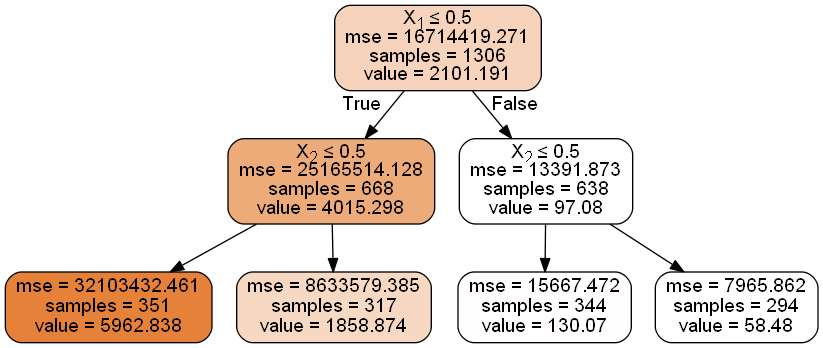

In [244]:
dot_data = StringIO()  

export_graphviz(dt, out_file=dot_data,  
                filled=True, rounded=True,
                special_characters=True)  

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())  


In [245]:
from sklearn import tree
dotfile = open("dt_all.dot", "w")
tree.export_graphviz(dt, out_file = dotfile, feature_names=X_train.columns)
dotfile.close()